In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel


# Function to load and prepare data
def load_and_prepare_data(filepath, sort_by='timestamp', ascending=False):
    """
    Load the dataset and prepare it by setting the correct index and sorting.
    
    Parameters:
        filepath (str): The path to the CSV file.
        sort_by (str): The column to sort by, default is 'timestamp'.
        ascending (bool): Whether to sort in ascending order, default is False.
    
    Returns:
        pd.DataFrame: The prepared DataFrame.
    """
    # Load data
    data = pd.read_csv(filepath)
    
    # Convert the 'timestamp' column to datetime format
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Set 'timestamp' as the index
    data.set_index('timestamp', inplace=True)
    
    # Sort the data by timestamp (most recent entries first)
    data.sort_values(by=sort_by, ascending=ascending, inplace=True)
    
    return data

# Load and prepare the dataset
data = load_and_prepare_data('SPY_2024-08.csv')

# Inspect the first few rows to ensure correct loading and sorting
print(data.head())


                        open    high      low    close   volume
timestamp                                                      
2024-08-23 20:00:00  562.130  562.13  562.130  562.130  1200215
2024-08-23 19:59:00  562.315  562.34  562.100  562.245     7567
2024-08-23 19:58:00  562.310  562.34  562.290  562.315      159
2024-08-23 19:57:00  562.400  562.40  562.295  562.340     4435
2024-08-23 19:56:00  562.330  562.40  562.330  562.400      390


In [2]:
from sklearn.preprocessing import MinMaxScaler

# Function to create the target variable
def create_target_variable(data, shift_by=1):
    """
    Create the target variable by shifting the close prices.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        shift_by (int): The number of periods to shift the close prices to create the target variable.
    
    Returns:
        pd.DataFrame: The DataFrame with the new target variable.
    """
    data['close_t+1'] = data['close'].shift(shift_by)
    return data

# Function to calculate log returns and scale volume
def calculate_log_return_and_scale_volume(data, shift_by=-1):
    """
    Calculate the log returns based on shifted close prices and scale the volume.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        shift_by (int): The number of periods to shift the close prices for log return calculation.
    
    Returns:
        pd.DataFrame: The DataFrame with the log return and scaled volume features added.
    """
    data['log_return'] = np.log(data['close'] / data['close'].shift(shift_by))
    scaler = MinMaxScaler()
    data['Scaled_Volume'] = scaler.fit_transform(data[['volume']])
    return data

# Apply these functions to the data
data = create_target_variable(data, shift_by=1)
data = calculate_log_return_and_scale_volume(data, shift_by=-1)

# Drop NaN values resulting from shifting operations
data.dropna(inplace=True)

# Inspect the first few rows to ensure everything is correct
print(data.head())


                        open    high      low    close  volume  close_t+1  \
timestamp                                                                   
2024-08-23 19:59:00  562.315  562.34  562.100  562.245    7567    562.130   
2024-08-23 19:58:00  562.310  562.34  562.290  562.315     159    562.245   
2024-08-23 19:57:00  562.400  562.40  562.295  562.340    4435    562.315   
2024-08-23 19:56:00  562.330  562.40  562.330  562.400     390    562.340   
2024-08-23 19:55:00  562.330  562.33  562.291  562.330     326    562.400   

                     log_return  Scaled_Volume  
timestamp                                       
2024-08-23 19:59:00   -0.000124       0.001146  
2024-08-23 19:58:00   -0.000044       0.000024  
2024-08-23 19:57:00   -0.000107       0.000672  
2024-08-23 19:56:00    0.000124       0.000059  
2024-08-23 19:55:00    0.000085       0.000049  


In [3]:
# Function to split data into training and testing sets
def split_data(data, features, target, test_size=0.2, shuffle=False):
    """
    Split the dataset into training and testing sets.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        features (list): The list of feature column names.
        target (str): The name of the target column.
        test_size (float): The proportion of the dataset to include in the test split.
        shuffle (bool): Whether to shuffle the data before splitting.
    
    Returns:
        tuple: Splits of the dataset (X_train, X_test, y_train, y_test).
    """
    X = data[features]
    y = data[target]
    return train_test_split(X, y, test_size=test_size, shuffle=shuffle)

# Define the features and target variable
features = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
target = 'close_t+1'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = split_data(data, features, target, test_size=0.2, shuffle=False)

# Inspect the shapes of the training and testing sets to confirm the split
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (12996, 6)
X_test shape: (3250, 6)
y_train shape: (12996,)
y_test shape: (3250,)


In [4]:
from sklearn.model_selection import GridSearchCV

# Function to perform hyperparameter tuning
def hyperparameter_tuning(X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV for Random Forest Regressor.
    
    Parameters:
        X_train (pd.DataFrame): The training feature set.
        y_train (pd.Series): The training target values.
    
    Returns:
        dict: The best parameters found by GridSearchCV.
        RandomForestRegressor: The best Random Forest model.
    """
    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    
    # Initialize the Random Forest Regressor
    rfr = RandomForestRegressor(random_state=42)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, 
                               cv=5, n_jobs=-1, verbose=2, 
                               scoring='neg_mean_squared_error')
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    return best_params, best_model

# Perform hyperparameter tuning
best_params, best_rfr_model = hyperparameter_tuning(X_train, y_train)

# Print the best parameters and the best model
print("Best Parameters Found: ", best_params)
print("Best Random Forest Model: ", best_rfr_model)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters Found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Random Forest Model:  RandomForestRegressor(max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, random_state=42)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_rfr_results(y_train, y_train_pred, y_test, y_test_pred, feature_importances, feature_names, data, last_n=70):
    """
    Generates and displays plots for Random Forest Regressor results including:
    - Actual vs Predicted for Training and Testing data
    - Residuals for Training and Testing data
    - Feature Importances
    - Actual vs Predicted values over time for Training and Testing data
    - Actual vs Predicted values over time for the last n data points

    Parameters:
        y_train (pd.Series): Actual target values for training data.
        y_train_pred (np.ndarray): Predicted target values for training data.
        y_test (pd.Series): Actual target values for testing data.
        y_test_pred (np.ndarray): Predicted target values for testing data.
        feature_importances (np.ndarray): Feature importances from the Random Forest model.
        feature_names (list): List of feature names corresponding to the importances.
        data (pd.DataFrame): Original dataset containing the features and target.
        last_n (int): Number of last data points to plot for Actual vs Predicted over time.
    """

    # Convert feature importances to a DataFrame for plotting
    feature_importances_df = pd.DataFrame(feature_importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

    # Plotting the results
    plt.figure(figsize=(25, 12))

    # Plot 1: Predicted vs Actual for Training data
    plt.subplot(2, 3, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.6)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Training Data: Actual vs Predicted')

    # Plot 2: Residuals for Training data
    plt.subplot(2, 3, 2)
    plt.scatter(y_train_pred, y_train - y_train_pred, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Training Data: Residuals')

    # Plot 3: Predicted vs Actual for Testing data
    plt.subplot(2, 3, 3)
    plt.scatter(y_test, y_test_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Testing Data: Actual vs Predicted')

    # Plot 4: Residuals for Testing data
    plt.subplot(2, 3, 4)
    plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Testing Data: Residuals')

    # Plot 5: Feature Importances
    plt.subplot(2, 3, 5)
    sns.barplot(x=feature_importances_df['Importance'], y=feature_importances_df.index)
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Features')

    # Plotting the actual vs predicted values for training and testing data
    plt.subplot(2, 3, 6)

    # Plot for training data
    plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
    plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

    # Plot for testing data
    plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
    plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

    plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plotting the actual vs predicted values over time for the last n data points
    plt.figure(figsize=(16, 8))

    # Select the last n data points
    time_series = data.index[-last_n:]
    y_test_actual_last_n = y_test[-last_n:]
    y_test_pred_last_n = y_test_pred[-last_n:]

    plt.plot(time_series, y_test_actual_last_n, label='Actual', color='blue', marker='o')
    plt.plot(time_series, y_test_pred_last_n, label='Predicted', color='orange', marker='o')

    plt.title(f'Actual vs Predicted values over time (Last {last_n} Data Points)')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [6]:
# Train the Random Forest model using the best hyperparameters
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate and save metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and save metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Store results in a dictionary
results = {
    'Model': ['Tuned Random Forest'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

# Convert the dictionary to a DataFrame and print it
results_df = pd.DataFrame(results)
print(results_df)

# Save the performance metrics to a CSV file
results_df.to_csv('tuned_model_performance_metrics.csv', index=False)


Training Data - RMSE: 0.37365653144038247, MAE: 0.07727616873902345, R²: 0.9992766913542027
Testing Data - RMSE: 0.8854772861890706, MAE: 0.3680047509245255, R²: 0.9945621007248246
                 Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  \
0  Tuned Random Forest    0.373657   0.885477   0.077276  0.368005  0.999277   

    Test R²  
0  0.994562  


Cross-Validation MSEs: [ 0.60095557  0.6732793   1.74618202  1.32446661 37.71901232]
Mean Cross-Validation MSE: 8.412779164860659


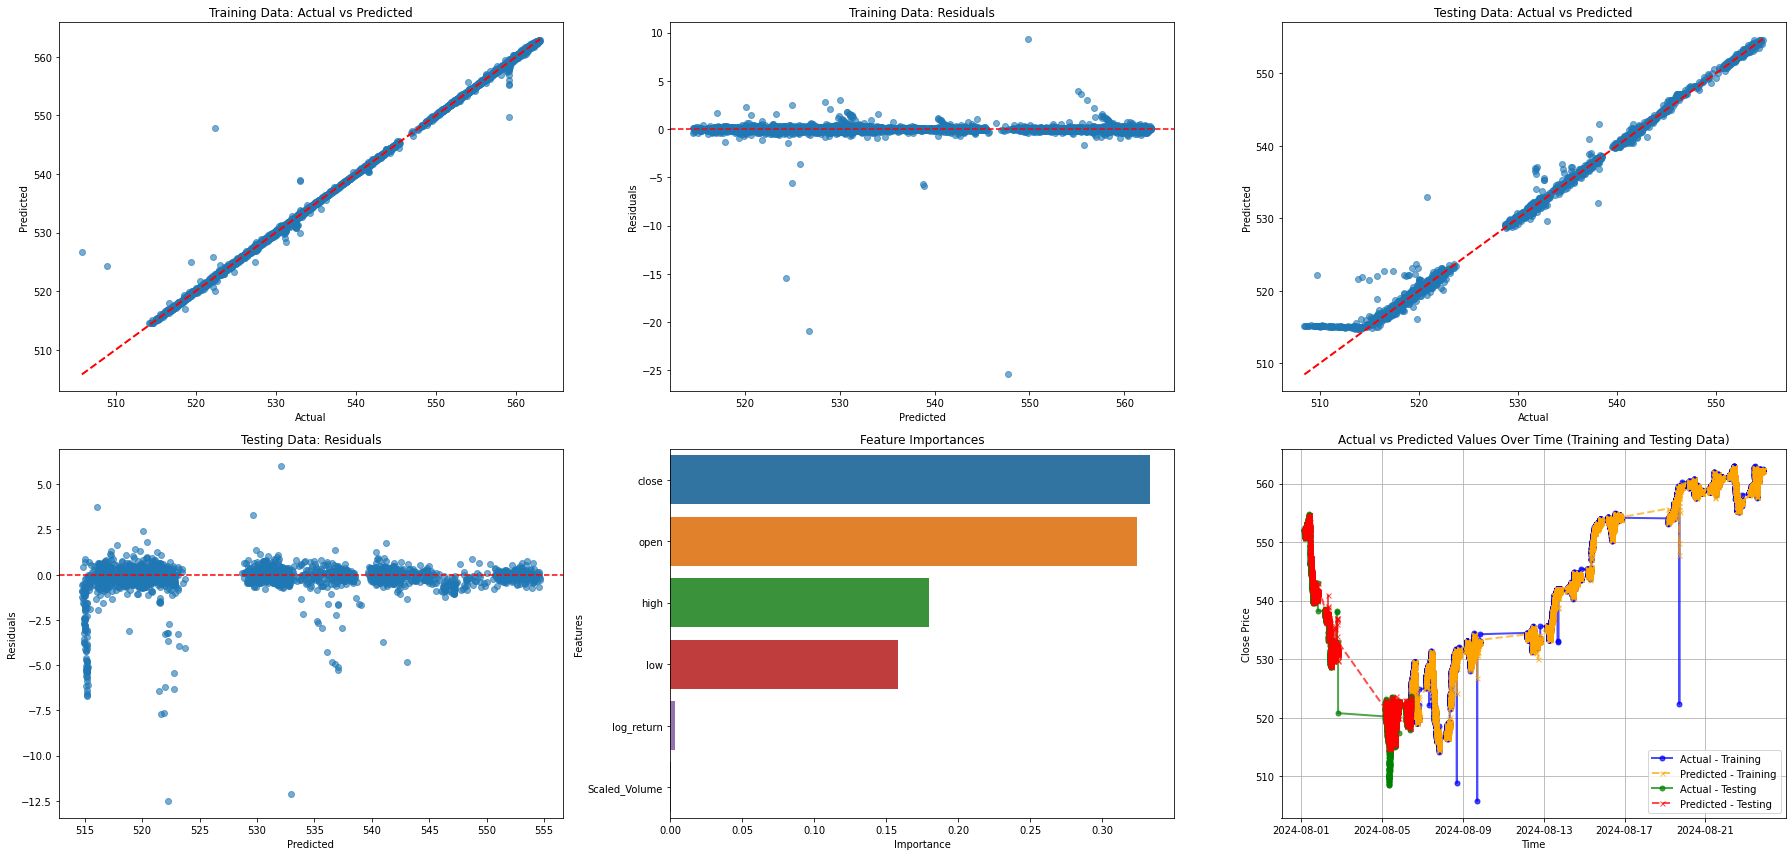

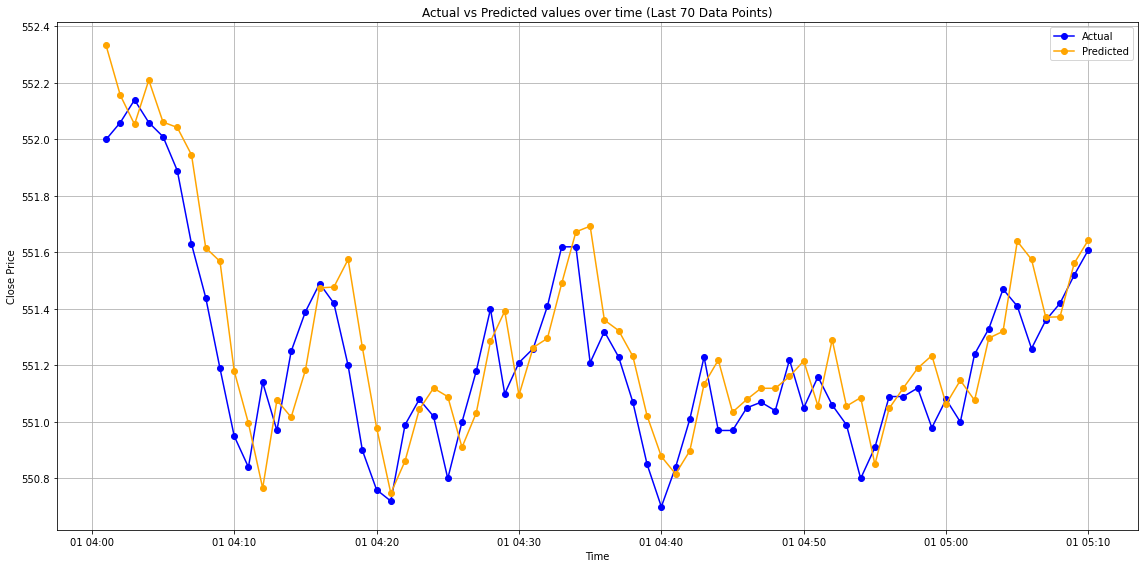

In [7]:
# Perform cross-validation for the tuned model
cv_mse = cross_val_score(best_rfr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_mse  # Convert to positive MSE

# Print the cross-validation results
print(f"Cross-Validation MSEs: {cv_mse}")
print(f"Mean Cross-Validation MSE: {cv_mse.mean()}")

# Save cross-validation results to a CSV file
cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse) + 1),
    'MSE': cv_mse
})
cv_results_df.to_csv('tuned_model_cross_validation_results.csv', index=False)

# Assuming you have trained your model and made predictions
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Call the plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=best_rfr_model.feature_importances_,
    feature_names=X_train.columns,
    data=data,
    last_n=70  # Customize as needed
)



In [8]:
import os

def perform_stat_test(cv_mse_base, cv_mse_new, model_name, output_folder="stat_test_results"):
    """
    Perform a paired t-test between the base model and the new model with a technical indicator.
    Then, save the results in a separate CSV file in the specified output folder.
    
    Parameters:
        cv_mse_base (np.ndarray): Cross-validation MSEs of the base model.
        cv_mse_new (np.ndarray): Cross-validation MSEs of the new model.
        model_name (str): Name of the model being tested.
        output_folder (str): The folder where the stat test results will be saved.
    
    Returns:
        None: The function saves the results to a CSV file.
    """
    # Perform the t-test
    t_stat, p_value = ttest_rel(cv_mse_base, cv_mse_new)
    print(f'{model_name} t-statistic: {t_stat}, p-value: {p_value}')
    
    # Create a DataFrame with the t-statistic and p-value
    stat_results = pd.DataFrame([{
        'Model': model_name,
        't-statistic': t_stat,
        'p-value': p_value
    }])
    
    # Ensure the output folder exists, create if it doesn't
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Define the file name for the stat test results
    file_name = f'{model_name.lower().replace(" ", "_")}_stat_test_results.csv'
    file_path = os.path.join(output_folder, file_name)
    
    # Save the statistical test results to the specified file
    stat_results.to_csv(file_path, index=False)
    
    print(f'Statistical results saved to {file_path}')


### Technical Indicators ###

## SMA 10

Training Data - RMSE: 0.3515993346246338, MAE: 0.06648414599438339, R²: 0.9993593681902518
Testing Data - RMSE: 0.7518555724484716, MAE: 0.3074228764071495, R²: 0.9960778104853124
SMA_10 Model t-statistic: -0.47214833766141046, p-value: 0.6614264249877972


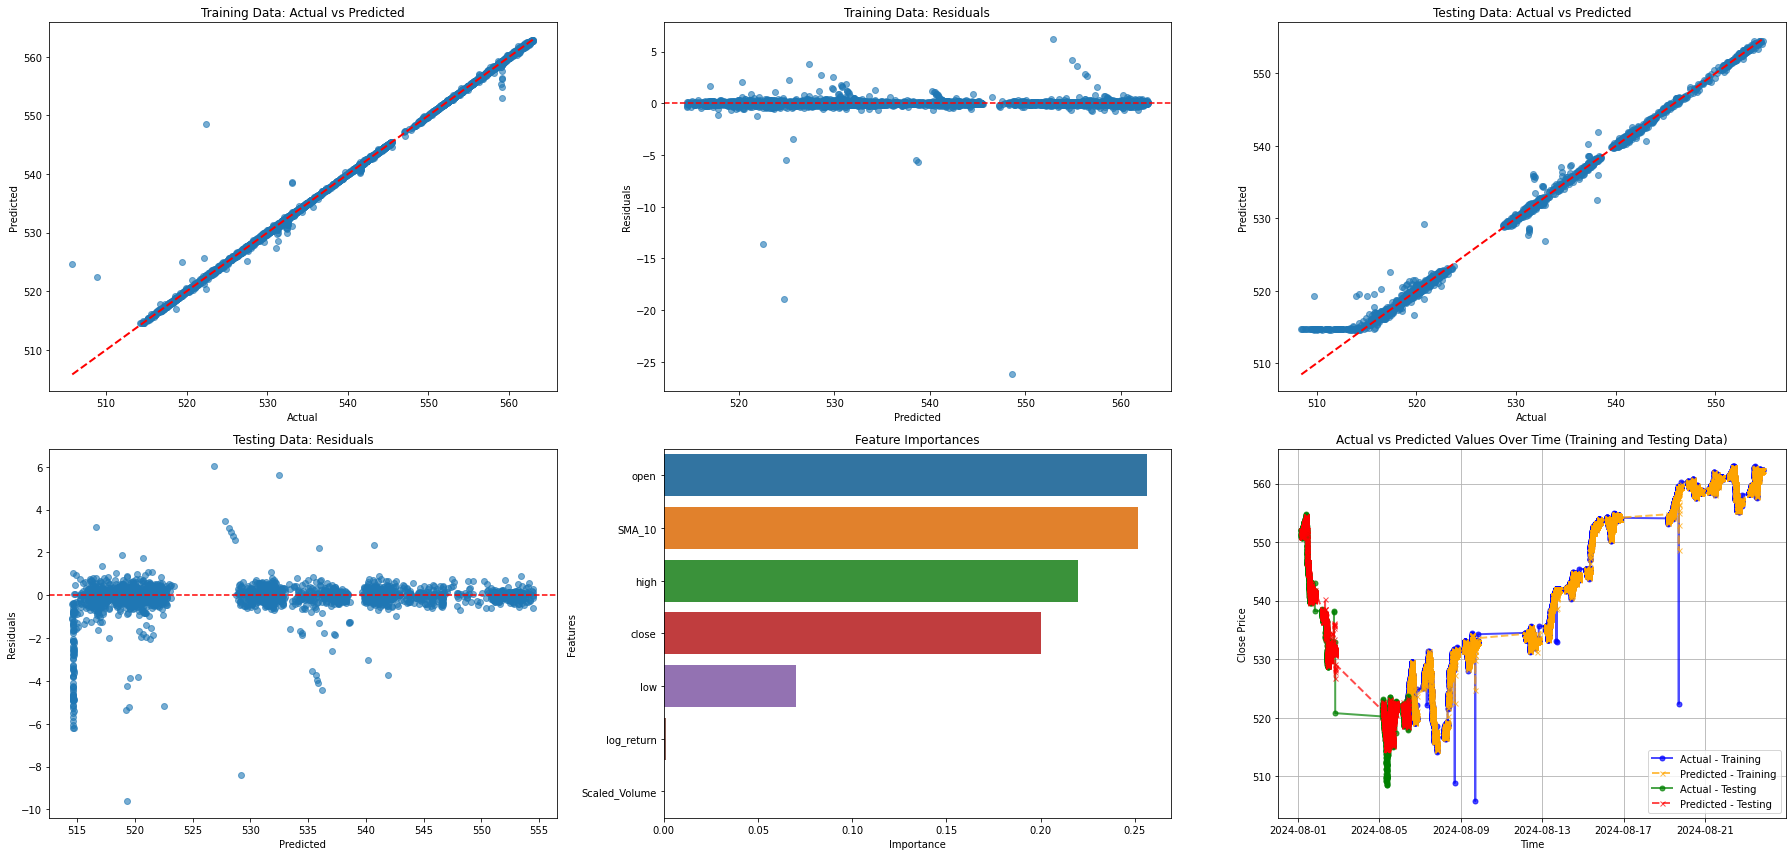

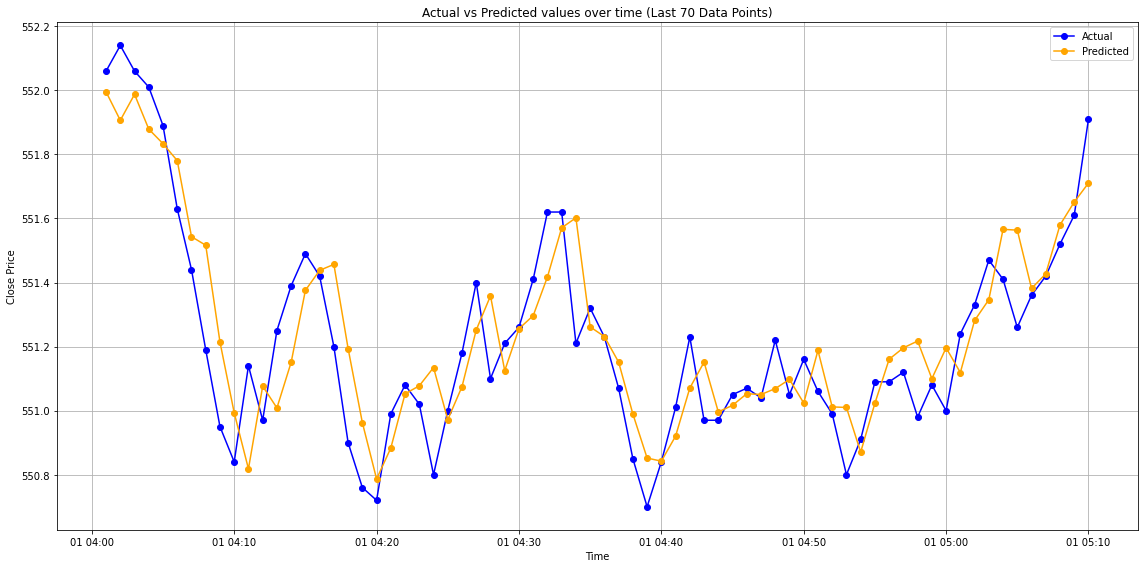

In [9]:
# Feature Engineering
data['SMA_10'] = data['close'].rolling(window=10).mean()

# Drop NaN values resulting from shift and rolling operations
data.dropna(inplace=True)

# Define the features and target variable, now including SMA_10
features_sma10 = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'SMA_10']
X = data[features_sma10]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with SMA_10
cv_mse_sma = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_sma = -cv_mse_sma  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus SMA_10
    features_base = ['open', 'high', 'low', 'close', 'log_return']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform cross-validation for the model with SMA_10
cv_mse_sma = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_sma = -cv_mse_sma  # Convert to positive MSE

# Perform statistical testing between the base model and SMA_10 model
t_stat, p_value = ttest_rel(cv_mse_base, cv_mse_sma)
print(f'SMA_10 Model t-statistic: {t_stat}, p-value: {p_value}')

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_sma10,
    data=data,
    last_n=70  # Customize as needed
)

# Combine performance metrics and statistical test results into one DataFrame
results_df = pd.DataFrame({
    'Model': ['SMA_10 Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2],
    't-statistic': [t_stat],
    'p-value': [p_value]
})

# Save the combined results to a CSV file
results_df.to_csv('sma10_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_sma) + 1),
    'MSE': cv_mse_sma
})
cv_results_df.to_csv('sma10_model_cross_validation_results.csv', index=False)


## RSI

Training Data - RMSE: 0.3894119754258461, MAE: 0.0755989243859273, R²: 0.9992142073229492
Testing Data - RMSE: 0.9214308602622957, MAE: 0.3761861341908809, R²: 0.9941101325903519
RSI Model t-statistic: -1.366589449633645, p-value: 0.24353046430040914


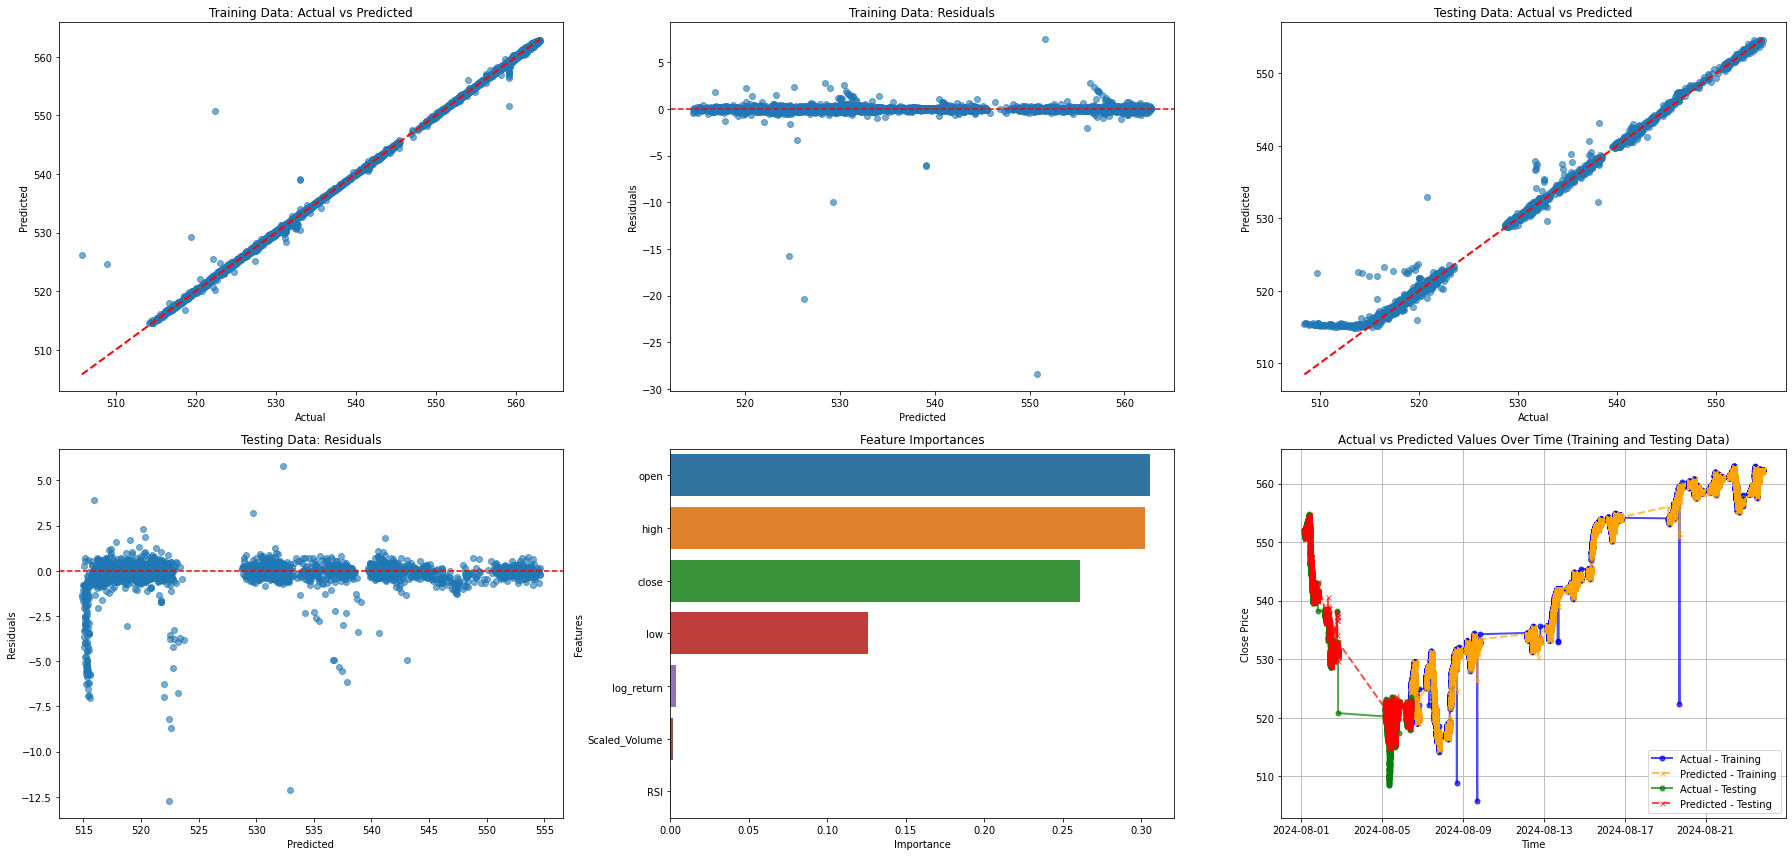

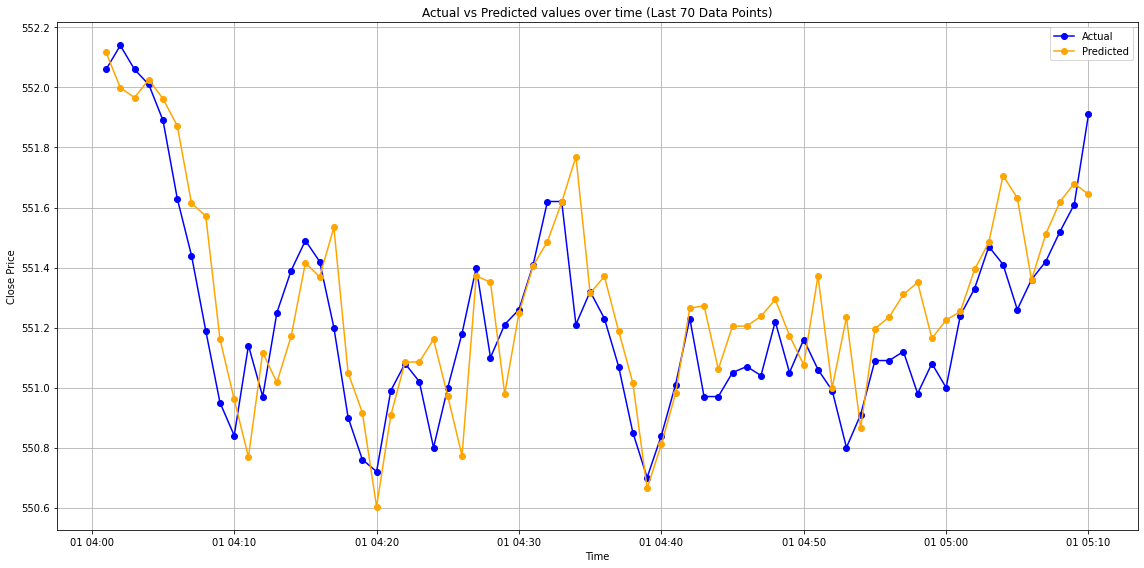

In [10]:
# Feature Engineering
window_length = 14

# Calculate daily price changes
delta = data['close'].diff()

# Make the positive gains (up) and negative gains (down) Series
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate the average gain and loss
avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
avg_loss = loss.rolling(window=window_length, min_periods=1).mean()

# Calculate RS (Relative Strength) and RSI
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Drop NaN values resulting from the RSI calculation
data.dropna(inplace=True)

# Define the features and target variable, now including RSI
features_rsi = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'RSI']
X = data[features_rsi]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with RSI
cv_mse_rsi = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_rsi = -cv_mse_rsi  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus RSI
    features_base = ['open', 'high', 'low', 'close', 'log_return']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and RSI model
t_stat, p_value = ttest_rel(cv_mse_base, cv_mse_rsi)
print(f'RSI Model t-statistic: {t_stat}, p-value: {p_value}')

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_rsi,
    data=data,
    last_n=70  # Customize as needed
)

# Combine performance metrics and statistical test results into one DataFrame
results_df = pd.DataFrame({
    'Model': ['RSI Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2],
    't-statistic': [t_stat],
    'p-value': [p_value]
})

# Save the combined results to a CSV file
results_df.to_csv('rsi_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_rsi) + 1),
    'MSE': cv_mse_rsi
})
cv_results_df.to_csv('rsi_model_cross_validation_results.csv', index=False)


## EMA 10

Training Data - RMSE: 0.3414723655977934, MAE: 0.06253630306887491, R²: 0.9993957724857956
Testing Data - RMSE: 0.7964227585135356, MAE: 0.32095384950210176, R²: 0.9955998514844941
EMA_10 Model t-statistic: 0.6067892401185219, p-value: 0.5767457325905093


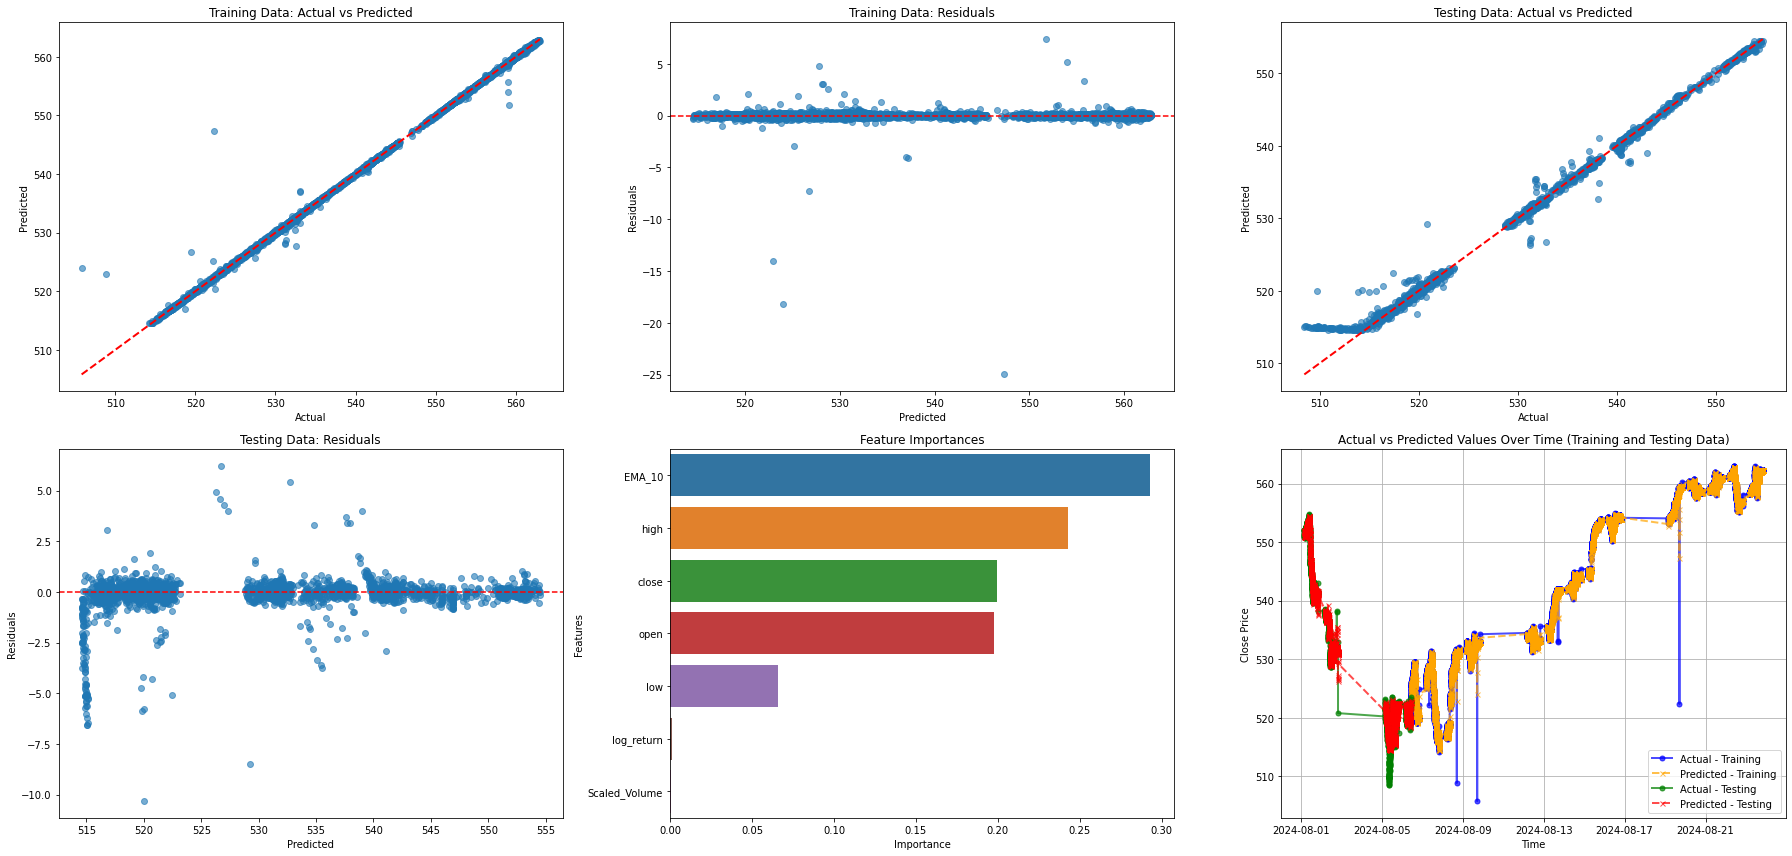

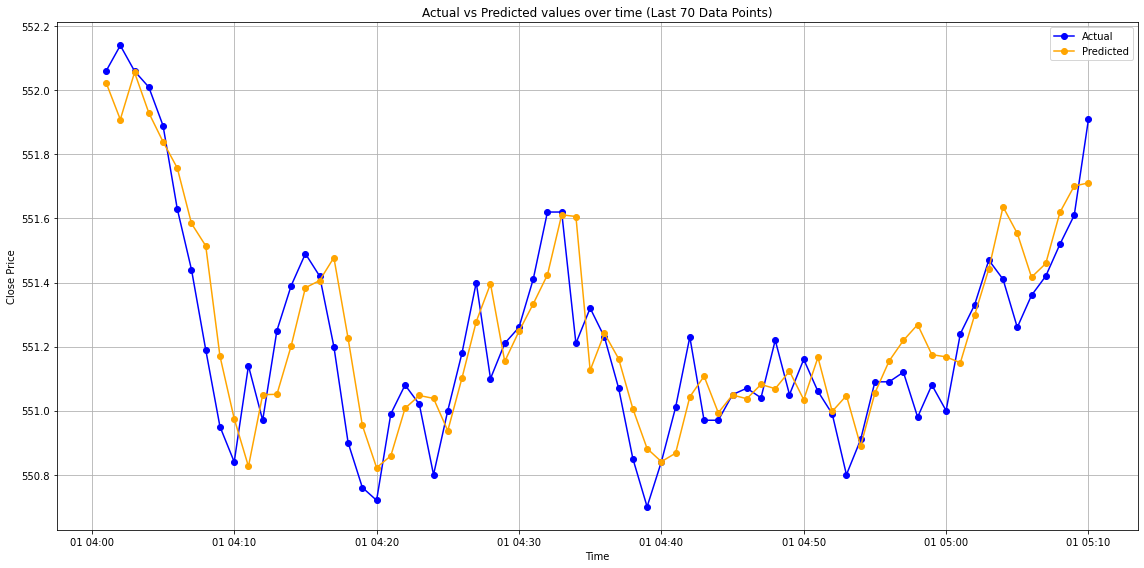

In [11]:
# Feature Engineering
data['EMA_10'] = data['close'].ewm(span=10, adjust=False).mean()

# Drop NaN values resulting from shift and rolling operations
data.dropna(inplace=True)

# Define the features and target variable, now including EMA_10
features_ema10 = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'EMA_10']
X = data[features_ema10]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with EMA_10
cv_mse_ema = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_ema = -cv_mse_ema  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus EMA_10
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and EMA_10 model
t_stat, p_value = ttest_rel(cv_mse_base, cv_mse_ema)
print(f'EMA_10 Model t-statistic: {t_stat}, p-value: {p_value}')

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_ema10,
    data=data,
    last_n=70  # Customize as needed
)

# Combine performance metrics and statistical test results into one DataFrame
results_df = pd.DataFrame({
    'Model': ['EMA_10 Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2],
    't-statistic': [t_stat],
    'p-value': [p_value]
})

# Save the combined results to a CSV file
results_df.to_csv('ema10_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_ema) + 1),
    'MSE': cv_mse_ema
})
cv_results_df.to_csv('ema10_model_cross_validation_results.csv', index=False)


## MACD

Training Data - RMSE: 0.3637927234156534, MAE: 0.06842228176777895, R²: 0.9993142001477828
Testing Data - RMSE: 0.8844055657477333, MAE: 0.3801290392349135, R²: 0.9945739605689784
MACD Model t-statistic: -1.7142586713162538, p-value: 0.16163270120016188


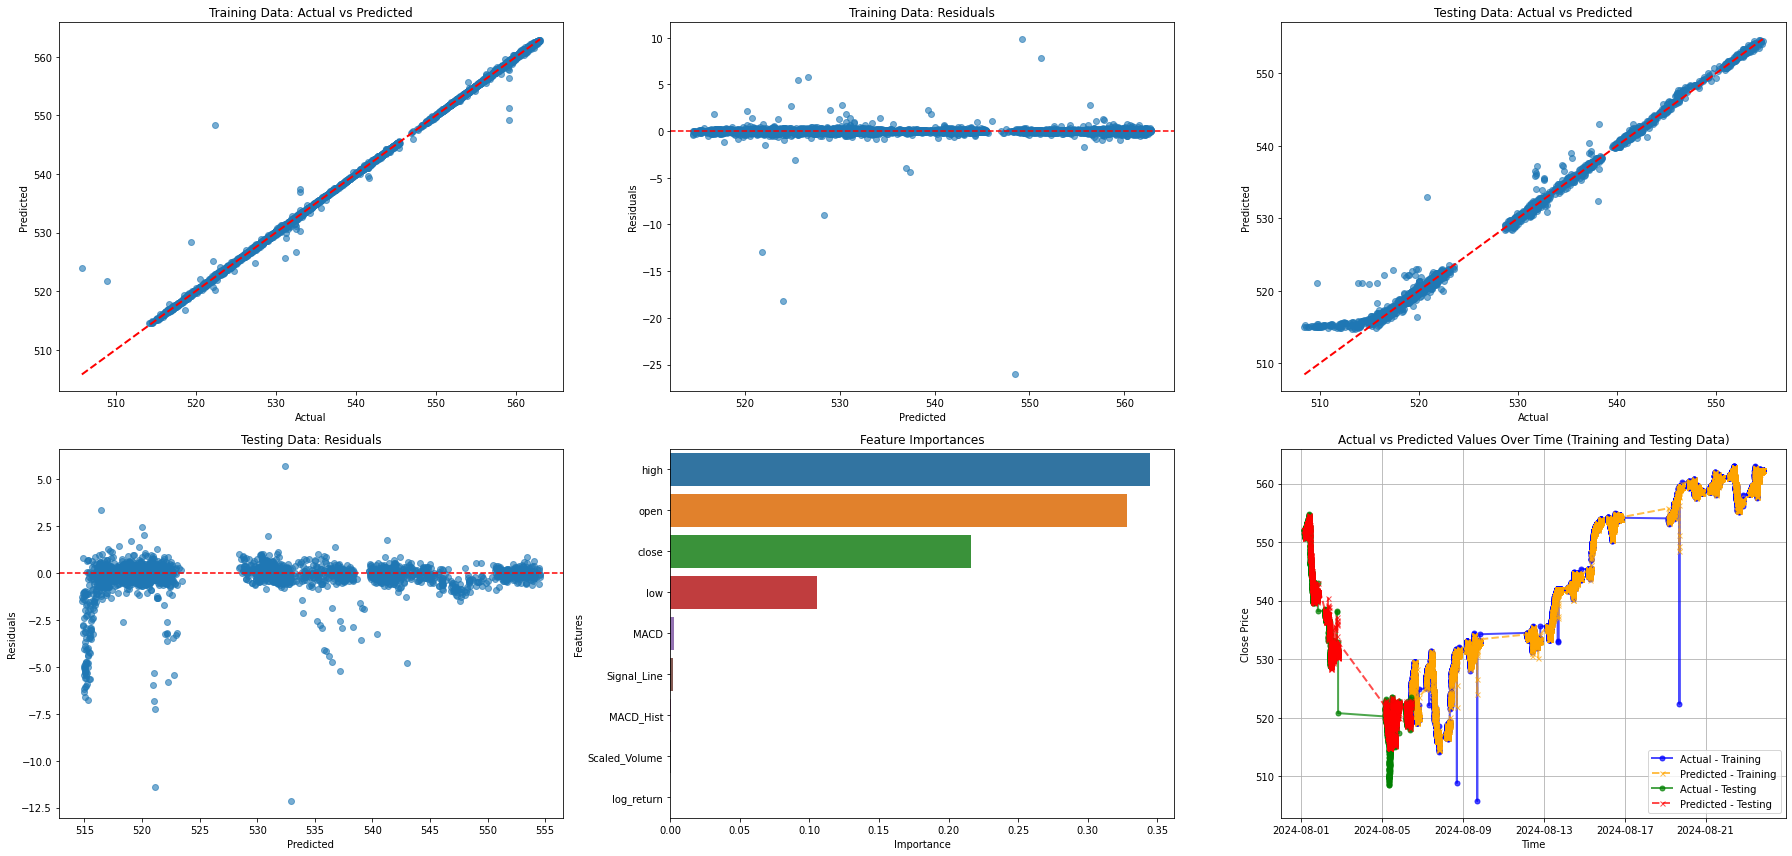

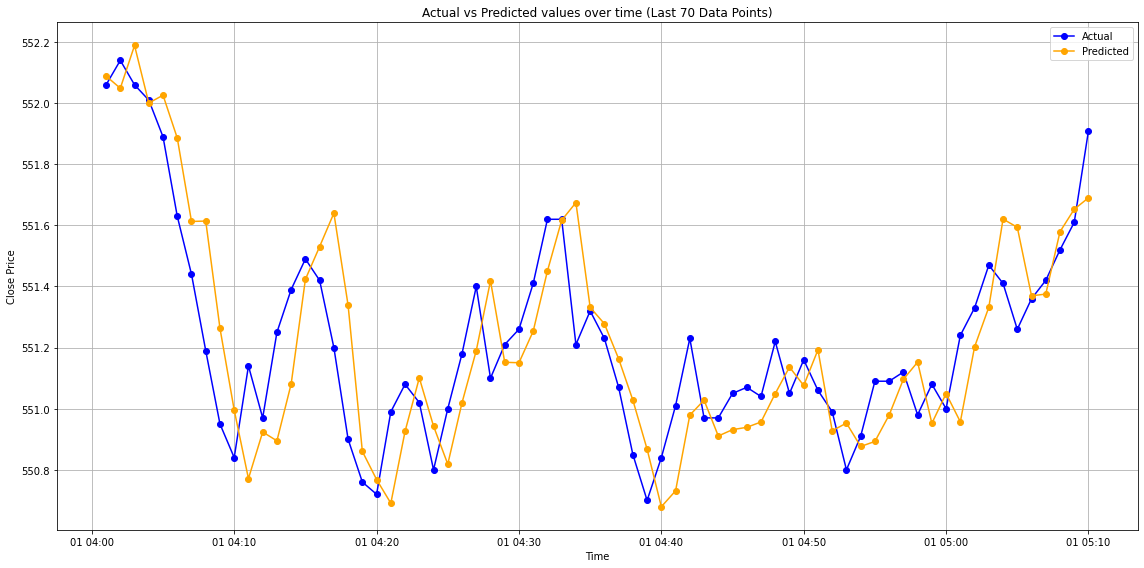

In [12]:
# Feature Engineering
data['EMA_12'] = data['close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Hist'] = data['MACD'] - data['Signal_Line']

# Drop NaN values resulting from the MACD calculations
data.dropna(inplace=True)

# Define the features and target variable, now including MACD-related features
features_macd = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'MACD', 'Signal_Line', 'MACD_Hist']
X = data[features_macd]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with MACD
cv_mse_macd = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_macd = -cv_mse_macd  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus MACD-related features
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and MACD model
t_stat, p_value = ttest_rel(cv_mse_base, cv_mse_macd)
print(f'MACD Model t-statistic: {t_stat}, p-value: {p_value}')

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_macd,
    data=data,
    last_n=70  # Customize as needed
)

# Combine performance metrics and statistical test results into one DataFrame
results_df = pd.DataFrame({
    'Model': ['MACD Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2],
    't-statistic': [t_stat],
    'p-value': [p_value]
})

# Save the combined results to a CSV file
results_df.to_csv('macd_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_macd) + 1),
    'MSE': cv_mse_macd
})
cv_results_df.to_csv('macd_model_cross_validation_results.csv', index=False)


## Bollinger Bands

Training Data - RMSE: 0.3629694913000067, MAE: 0.06400211098647983, R²: 0.9993169268841402
Testing Data - RMSE: 0.774639048911037, MAE: 0.3351447128635327, R²: 0.9958392843885382
Bollinger Bands Model t-statistic: 0.11925390880899087, p-value: 0.9108235780141091


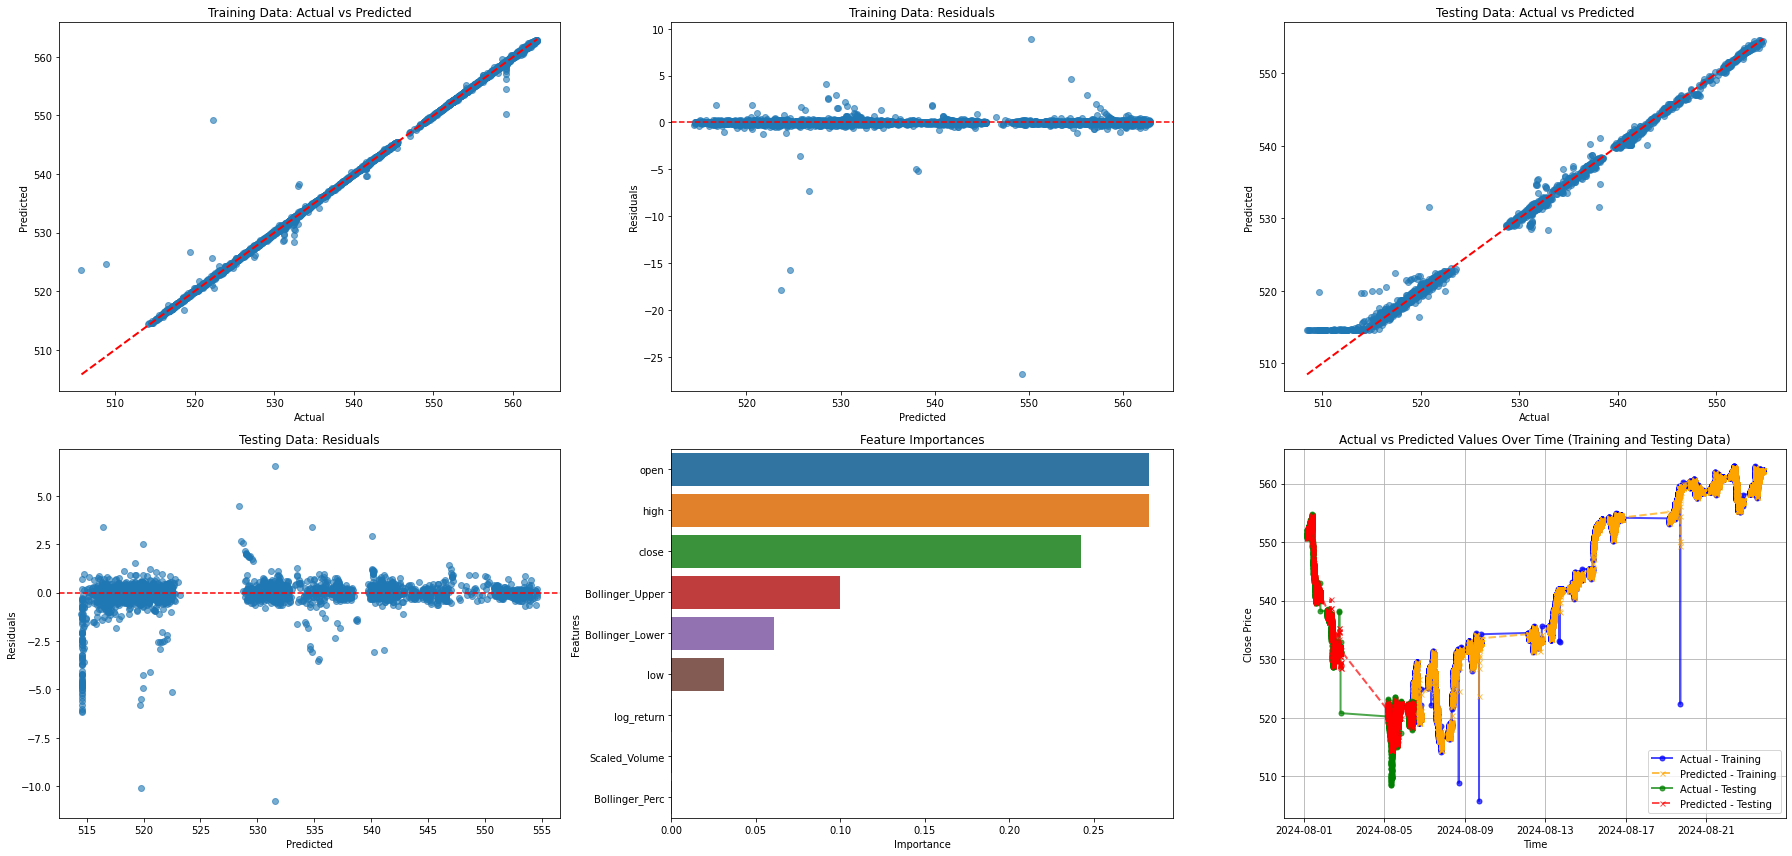

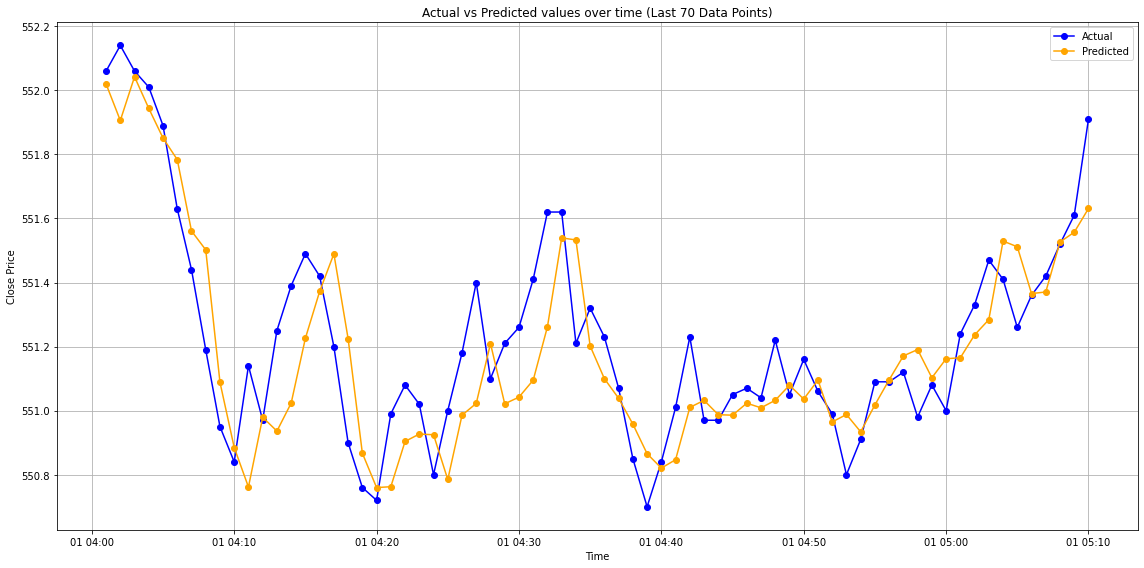

In [13]:
# Feature Engineering
data['SMA_20'] = data['close'].rolling(window=20).mean()
data['STD_20'] = data['close'].rolling(window=20).std()
data['Bollinger_Upper'] = data['SMA_20'] + (data['STD_20'] * 2)
data['Bollinger_Lower'] = data['SMA_20'] - (data['STD_20'] * 2)

# Optional: Distance from Bollinger Bands
data['Bollinger_Perc'] = (data['close'] - data['Bollinger_Lower']) / (data['Bollinger_Upper'] - data['Bollinger_Lower'])

# Drop NaN values resulting from the Bollinger Bands calculations
data.dropna(inplace=True)

# Define the features and target variable, now including Bollinger Bands-related features
features_bollinger = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'Bollinger_Upper', 'Bollinger_Lower', 'Bollinger_Perc']
X = data[features_bollinger]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with Bollinger Bands
cv_mse_bollinger = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_bollinger = -cv_mse_bollinger  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus Bollinger Bands-related features
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and Bollinger Bands model
t_stat, p_value = ttest_rel(cv_mse_base, cv_mse_bollinger)
print(f'Bollinger Bands Model t-statistic: {t_stat}, p-value: {p_value}')

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_bollinger,
    data=data,
    last_n=70  # Customize as needed
)

# Combine performance metrics and statistical test results into one DataFrame
results_df = pd.DataFrame({
    'Model': ['Bollinger Bands Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2],
    't-statistic': [t_stat],
    'p-value': [p_value]
})

# Save the combined results to a CSV file
results_df.to_csv('bollinger_bands_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_bollinger) + 1),
    'MSE': cv_mse_bollinger
})
cv_results_df.to_csv('bollinger_bands_model_cross_validation_results.csv', index=False)


## Stochastic Oscillator

Training Data - RMSE: 0.37383213949623617, MAE: 0.07252990539923705, R²: 0.999275190818498
Testing Data - RMSE: 0.9493610343090552, MAE: 0.38974821082032657, R²: 0.9937533360878119
Stochastic Oscillator Model t-statistic: -1.4787353001748098, p-value: 0.21329316995832218


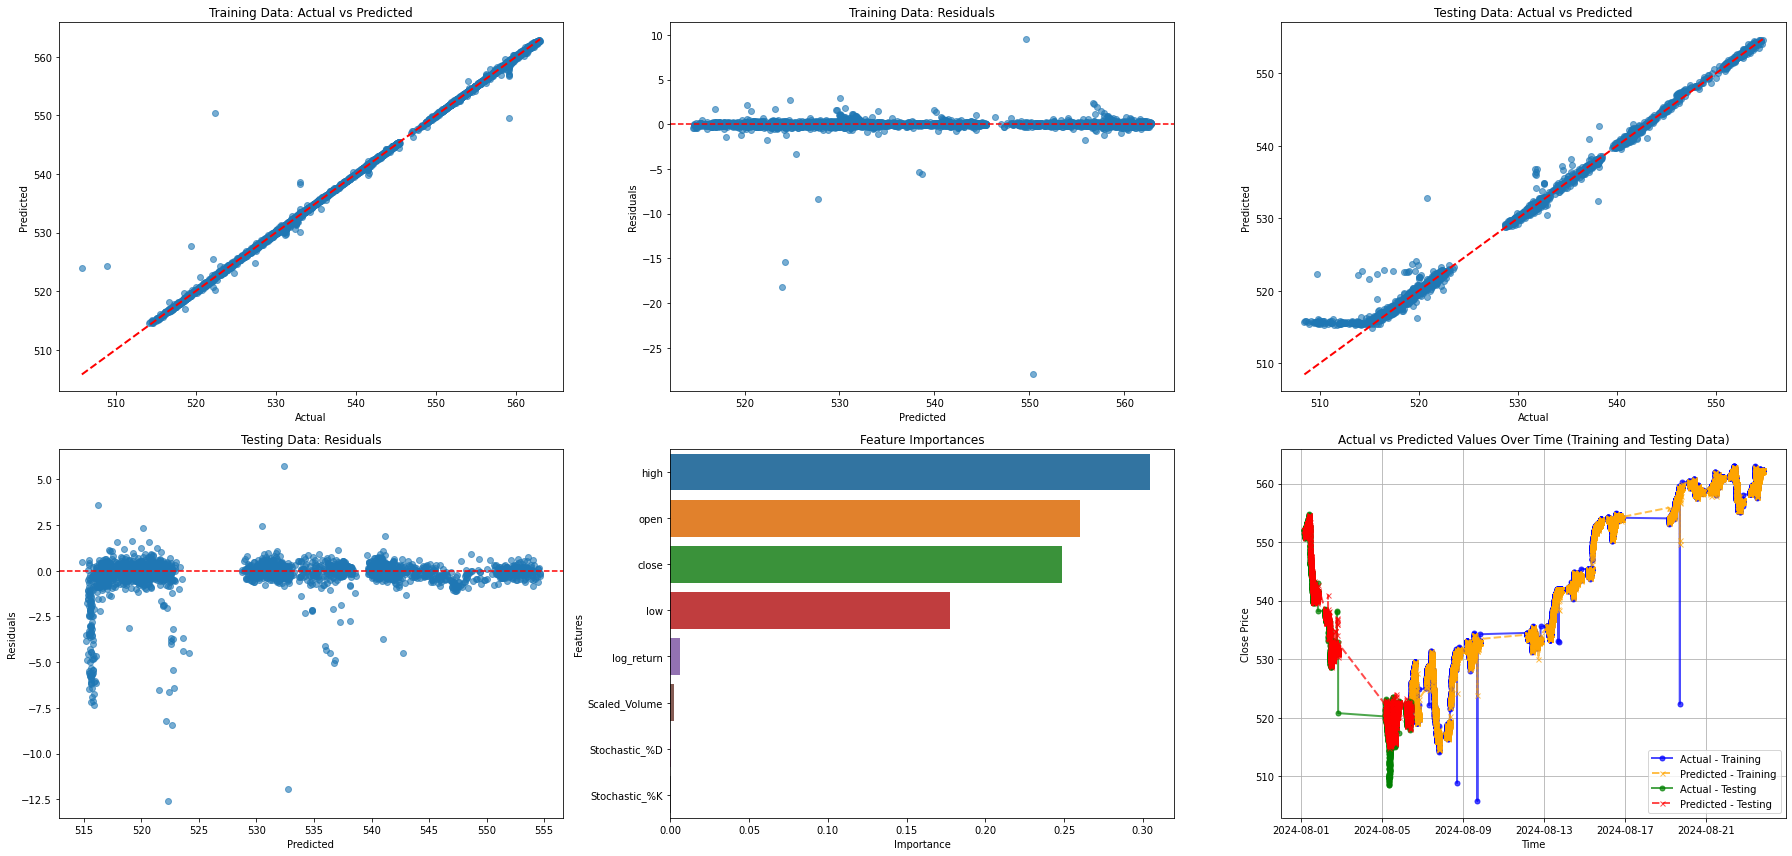

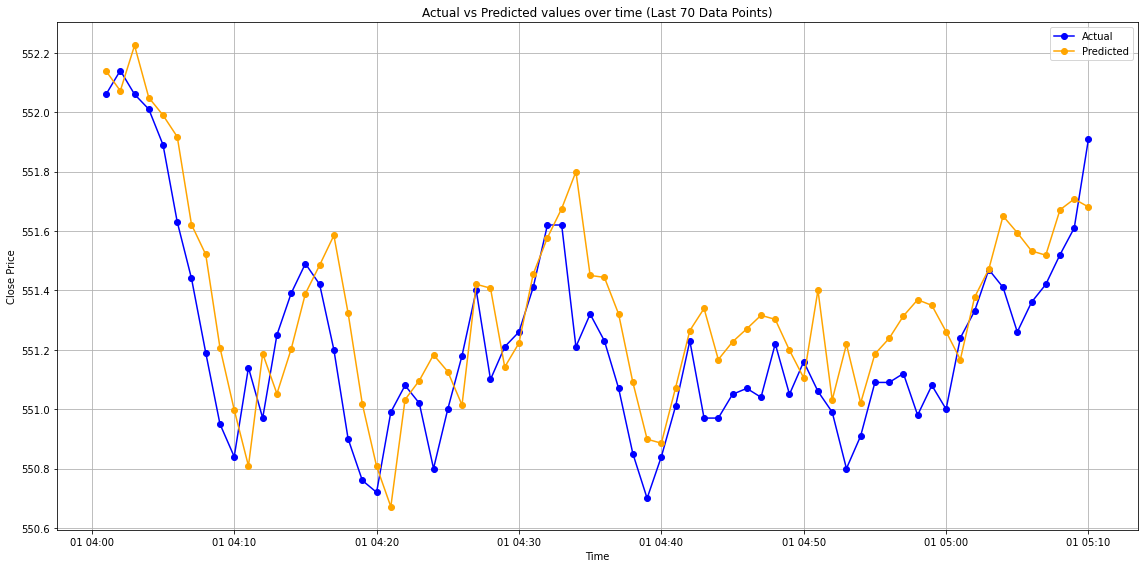

In [14]:
# Feature Engineering
data['Lowest_Low_14'] = data['low'].rolling(window=14).min()
data['Highest_High_14'] = data['high'].rolling(window=14).max()
data['Stochastic_%K'] = 100 * ((data['close'] - data['Lowest_Low_14']) / (data['Highest_High_14'] - data['Lowest_Low_14']))
data['Stochastic_%D'] = data['Stochastic_%K'].rolling(window=3).mean()

# Drop NaN values resulting from the Stochastic Oscillator calculation
data.dropna(inplace=True)

# Define the features and target variable, now including the Stochastic Oscillator
features_stochastic = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'Stochastic_%K', 'Stochastic_%D']
X = data[features_stochastic]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with Stochastic Oscillator
cv_mse_stochastic = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_stochastic = -cv_mse_stochastic  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus the Stochastic Oscillator-related features
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and Stochastic Oscillator model
t_stat, p_value = ttest_rel(cv_mse_base, cv_mse_stochastic)
print(f'Stochastic Oscillator Model t-statistic: {t_stat}, p-value: {p_value}')

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_stochastic,
    data=data,
    last_n=70  # Customize as needed
)

# Combine performance metrics and statistical test results into one DataFrame
results_df = pd.DataFrame({
    'Model': ['Stochastic Oscillator Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2],
    't-statistic': [t_stat],
    'p-value': [p_value]
})

# Save the combined results to a CSV file
results_df.to_csv('stochastic_oscillator_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_stochastic) + 1),
    'MSE': cv_mse_stochastic
})
cv_results_df.to_csv('stochastic_oscillator_model_cross_validation_results.csv', index=False)


## Fibbonnacci Retracement

Training Data - RMSE: 0.3705333494741463, MAE: 0.07178921450866856, R²: 0.9992876655881805
Testing Data - RMSE: 1.1904092705980007, MAE: 0.46833628626159257, R²: 0.9901831712370084
Fibonacci Retracement Model t-statistic: -1.9397281388909, p-value: 0.12441621845297546


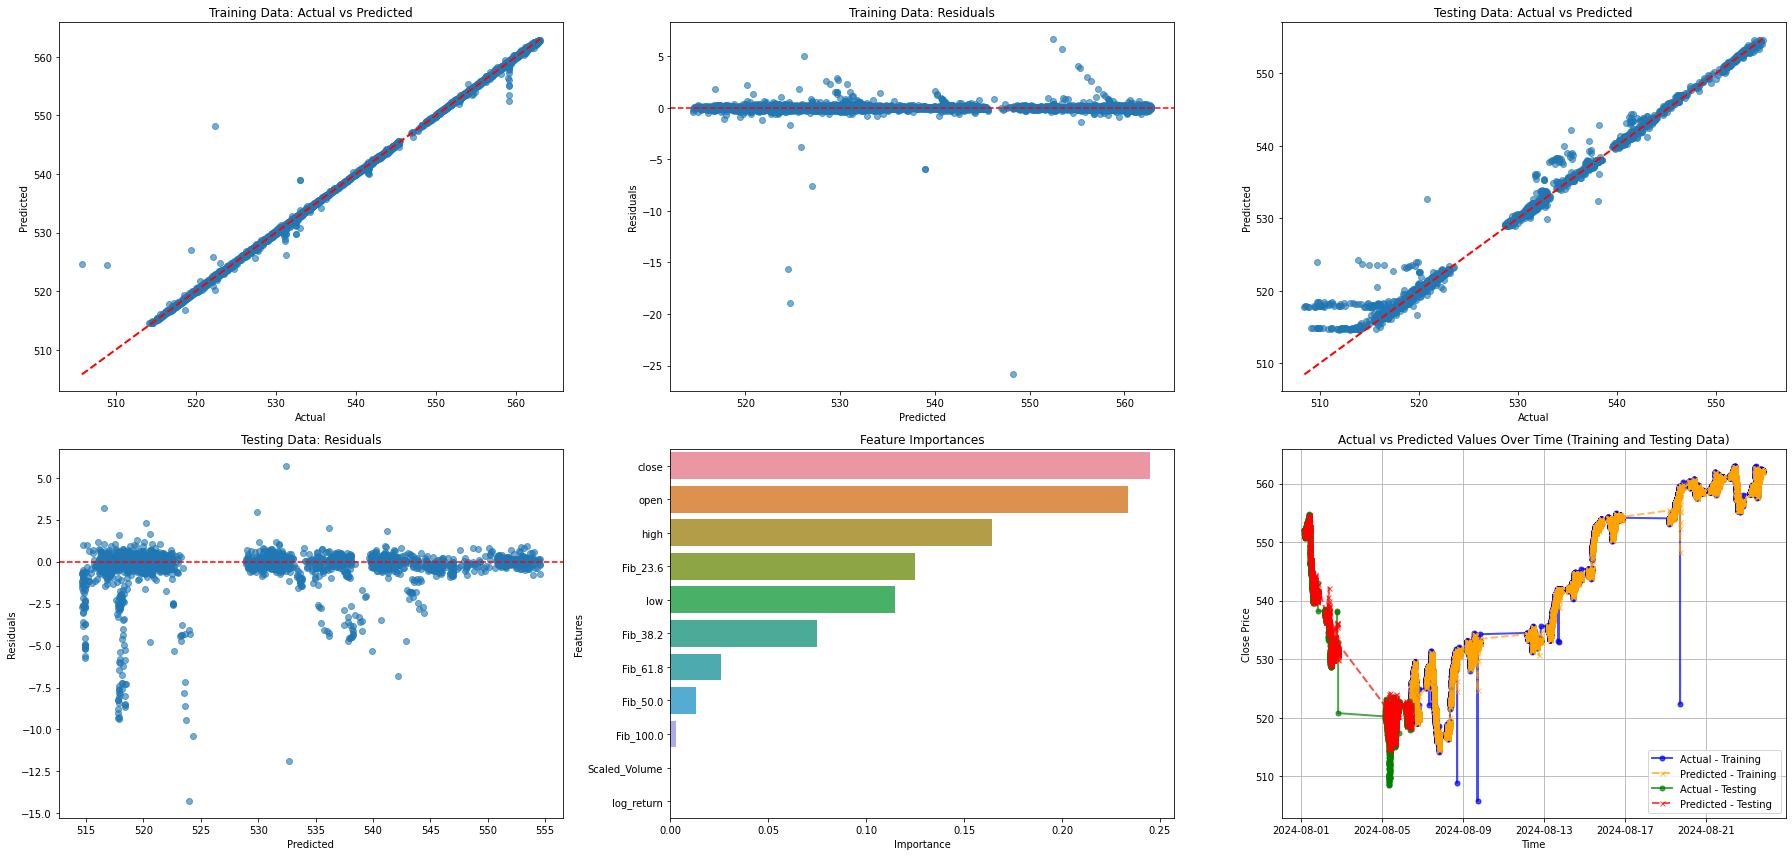

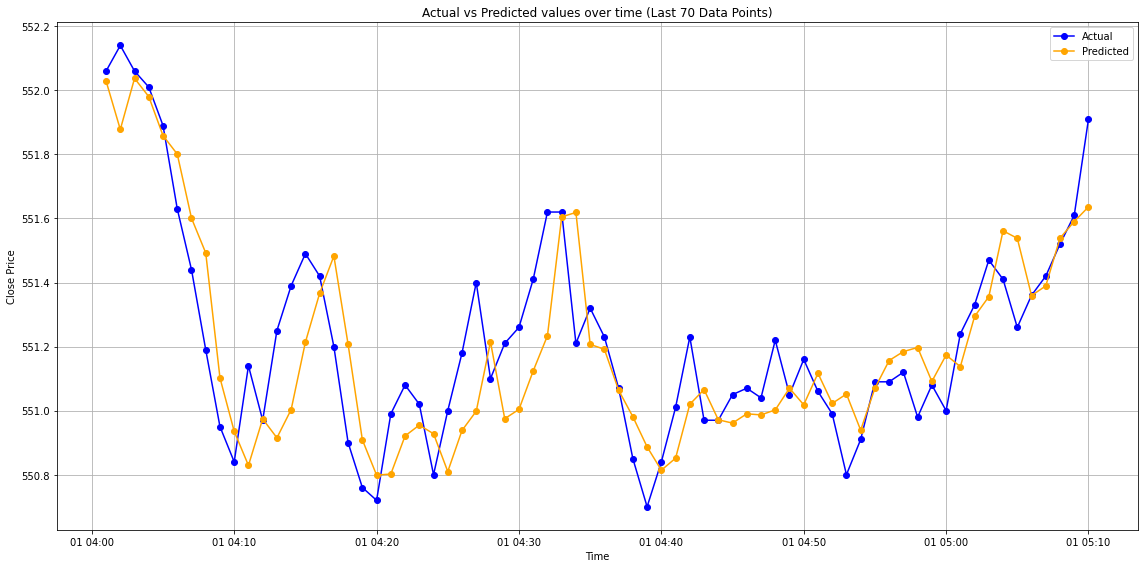

In [15]:
# Feature Engineering
lookback_period = 20  # You can adjust this period based on your needs

data['Swing_High'] = data['high'].rolling(window=lookback_period).max()
data['Swing_Low'] = data['low'].rolling(window=lookback_period).min()

# Fibonacci levels
data['Fib_23.6'] = data['Swing_High'] - (data['Swing_High'] - data['Swing_Low']) * 0.236
data['Fib_38.2'] = data['Swing_High'] - (data['Swing_High'] - data['Swing_Low']) * 0.382
data['Fib_50.0'] = data['Swing_High'] - (data['Swing_High'] - data['Swing_Low']) * 0.5
data['Fib_61.8'] = data['Swing_High'] - (data['Swing_High'] - data['Swing_Low']) * 0.618
data['Fib_100.0'] = data['Swing_Low']  # This is the same as Swing_Low

# Drop NaN values resulting from rolling operations
data.dropna(inplace=True)

# Define the features and target variable, now including Fibonacci Retracement levels
features_fibonacci = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 
                      'Fib_23.6', 'Fib_38.2', 'Fib_50.0', 'Fib_61.8', 'Fib_100.0']
X = data[features_fibonacci]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with Fibonacci Retracement
cv_mse_fibonacci = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_fibonacci = -cv_mse_fibonacci  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus Fibonacci Retracement-related features
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and Fibonacci Retracement model
t_stat, p_value = ttest_rel(cv_mse_base, cv_mse_fibonacci)
print(f'Fibonacci Retracement Model t-statistic: {t_stat}, p-value: {p_value}')

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_fibonacci,
    data=data,
    last_n=70  # Customize as needed
)

# Combine performance metrics and statistical test results into one DataFrame
results_df = pd.DataFrame({
    'Model': ['Fibonacci Retracement Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2],
    't-statistic': [t_stat],
    'p-value': [p_value]
})

# Save the combined results to a CSV file
results_df.to_csv('fibonacci_retracement_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_fibonacci) + 1),
    'MSE': cv_mse_fibonacci
})
cv_results_df.to_csv('fibonacci_retracement_model_cross_validation_results.csv', index=False)


## ADX

Training Data - RMSE: 0.3613559967197793, MAE: 0.06968967390165155, R²: 0.9993224840240855
Testing Data - RMSE: 0.894066590495887, MAE: 0.3737499953928366, R²: 0.9944624412390152
ADX Model t-statistic: -1.479871308563313, p-value: 0.21300697782282818


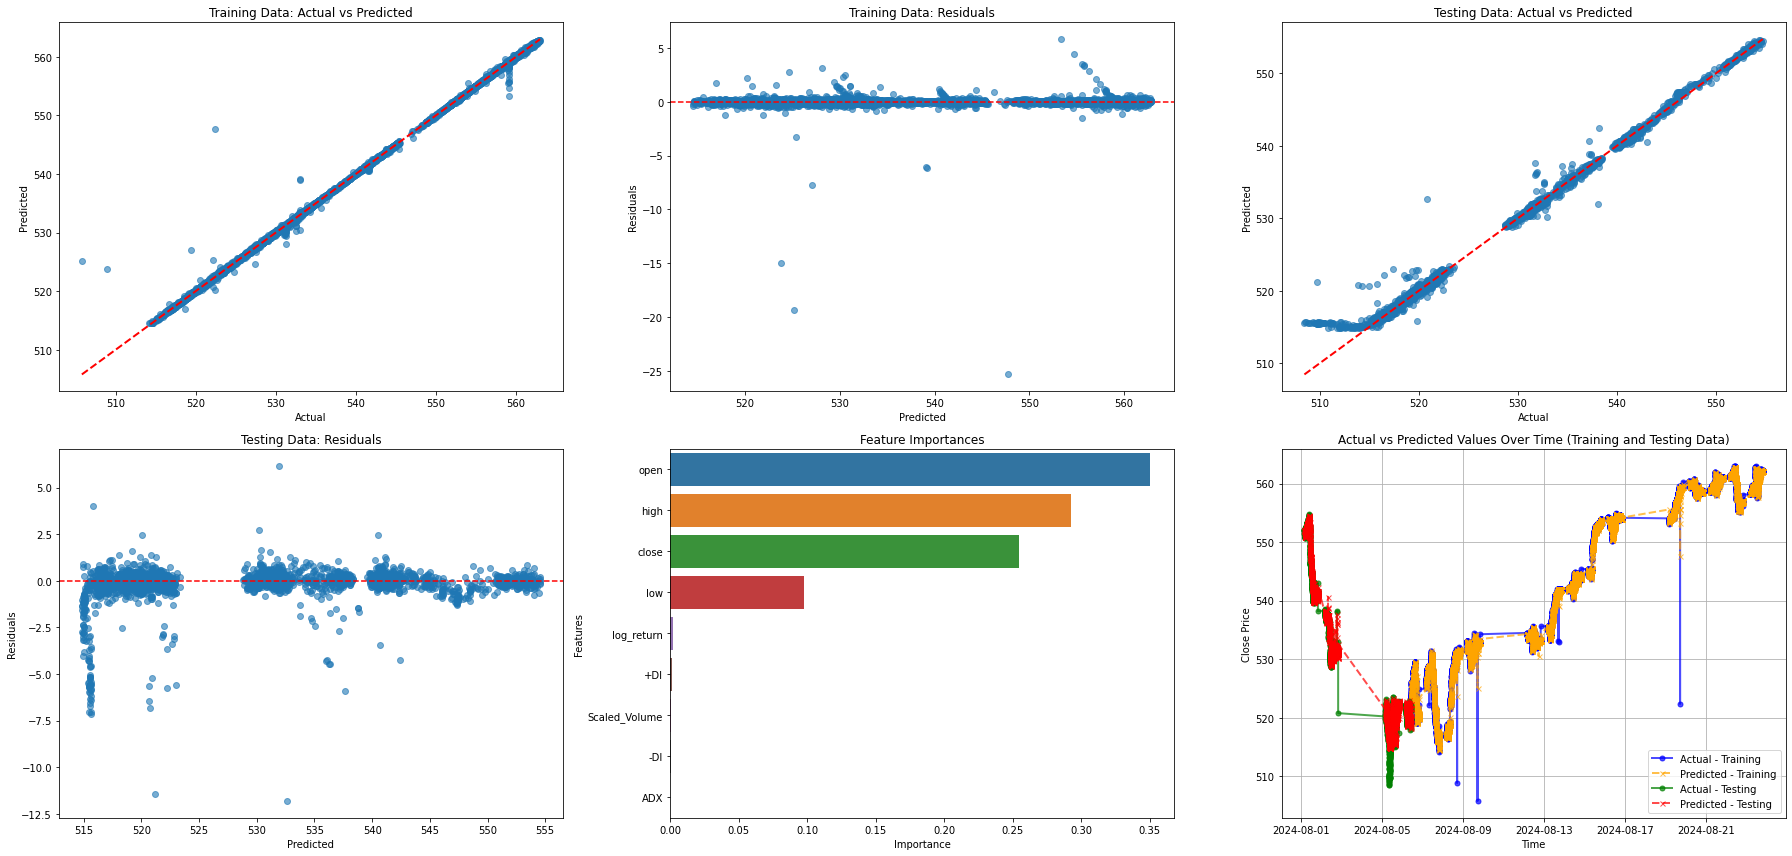

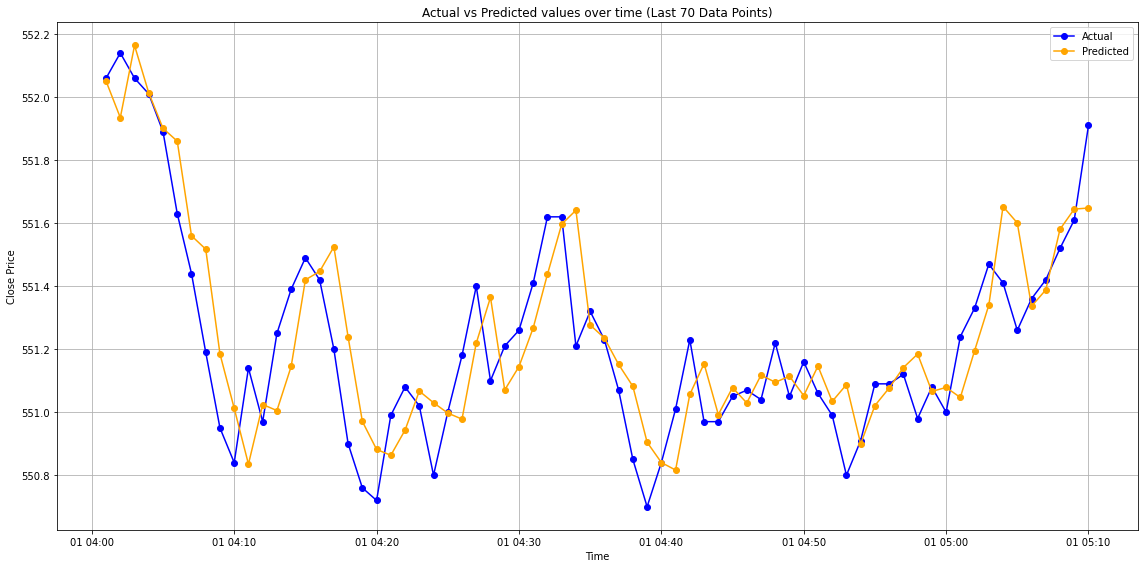

In [16]:
# Feature Engineering for ADX
data['High-Low'] = data['high'] - data['low']
data['High-Close'] = np.abs(data['high'] - data['close'].shift(1))
data['Low-Close'] = np.abs(data['low'] - data['close'].shift(1))
data['TR'] = data[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)

data['+DM'] = np.where((data['high'] - data['high'].shift(1)) > (data['low'].shift(1) - data['low']), 
                       data['high'] - data['high'].shift(1), 0)
data['-DM'] = np.where((data['low'].shift(1) - data['low']) > (data['high'] - data['high'].shift(1)), 
                       data['low'].shift(1) - data['low'], 0)

data['+DI'] = 100 * (data['+DM'].ewm(alpha=1/14, adjust=False).mean() / data['TR'].ewm(alpha=1/14, adjust=False).mean())
data['-DI'] = 100 * (data['-DM'].ewm(alpha=1/14, adjust=False).mean() / data['TR'].ewm(alpha=1/14, adjust=False).mean())

data['DX'] = 100 * np.abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI'])
data['ADX'] = data['DX'].ewm(alpha=1/14, adjust=False).mean()

# Drop NaN values resulting from rolling operations
data.dropna(inplace=True)

# Define the features and target variable, now including ADX
features_adx = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', '+DI', '-DI', 'ADX']
X = data[features_adx]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with ADX
cv_mse_adx = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_adx = -cv_mse_adx  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus ADX-related features
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and ADX model
t_stat, p_value = ttest_rel(cv_mse_base, cv_mse_adx)
print(f'ADX Model t-statistic: {t_stat}, p-value: {p_value}')

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_adx,
    data=data,
    last_n=70  # Customize as needed
)

# Combine performance metrics and statistical test results into one DataFrame
results_df = pd.DataFrame({
    'Model': ['ADX Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2],
    't-statistic': [t_stat],
    'p-value': [p_value]
})

# Save the combined results to a CSV file
results_df.to_csv('adx_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_adx) + 1),
    'MSE': cv_mse_adx
})
cv_results_df.to_csv('adx_model_cross_validation_results.csv', index=False)


## VWAP

Training Data - RMSE: 0.3634279175749099, MAE: 0.0749619636517937, R²: 0.9993146923511206
Testing Data - RMSE: 1.9210033311303947, MAE: 1.3227576216862293, R²: 0.9744356443557339
VWAP Model t-statistic: -1.8737656428273552, p-value: 0.13424520551329167


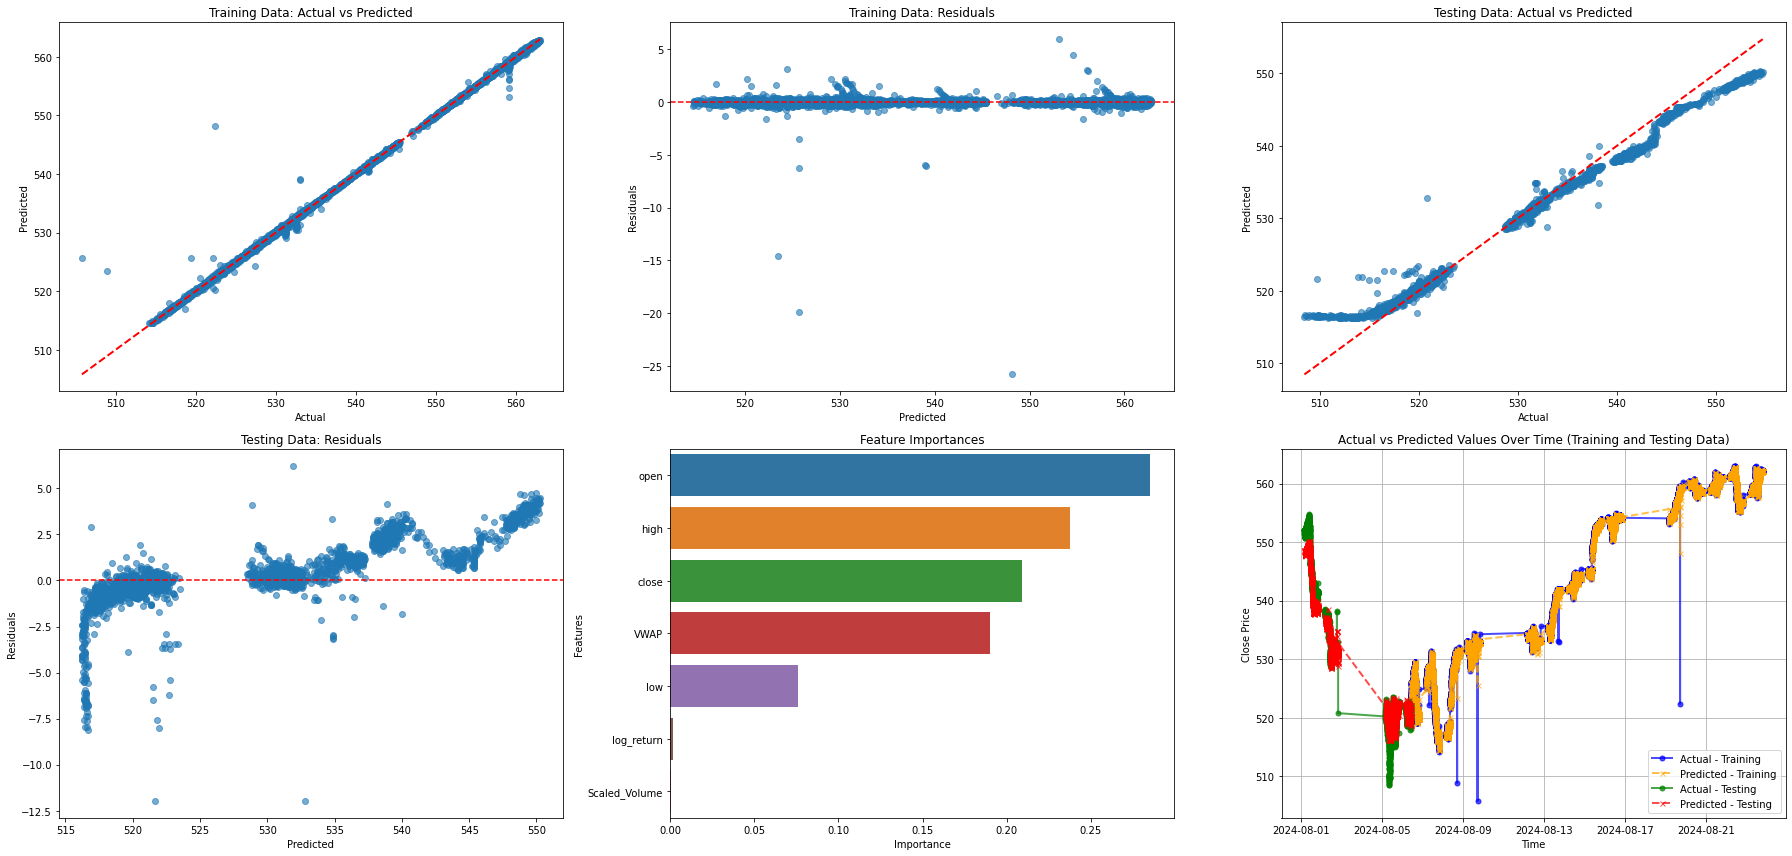

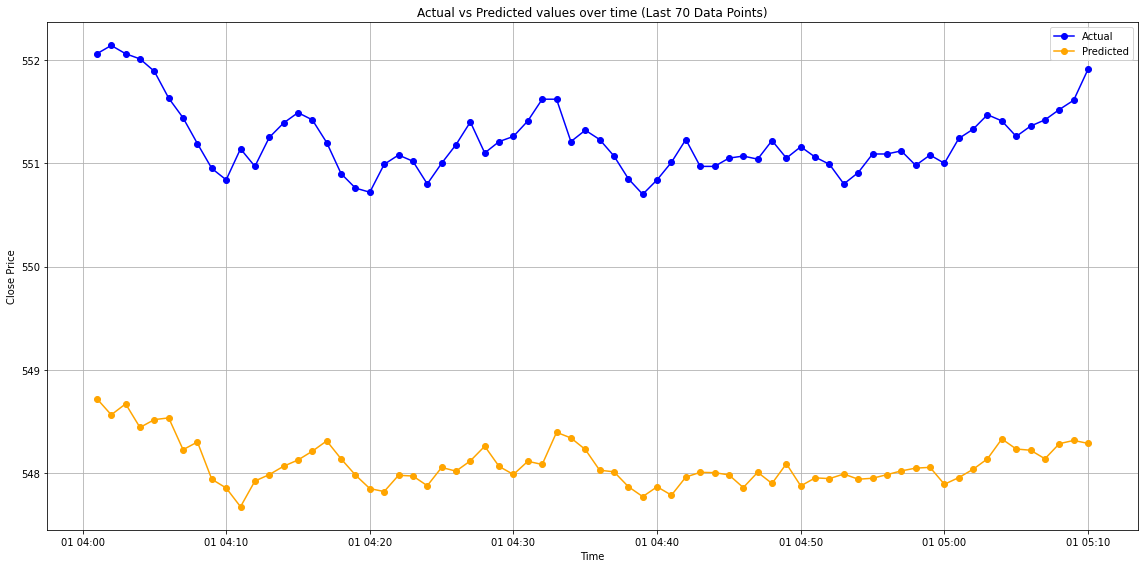

In [17]:
# Feature Engineering for VWAP
# VWAP is typically calculated on a per-day basis, but since we have minute data, we'll calculate it per minute based on intraday data.
# If data spans multiple days, ensure that the calculation is reset daily.

data['VWAP'] = (data['volume'] * (data['high'] + data['low'] + data['close']) / 3).cumsum() / data['volume'].cumsum()

# Scaling features including VWAP and closing price
scaler = MinMaxScaler()
data[['Scaled_Volume', 'VWAP', 'close']] = scaler.fit_transform(data[['volume', 'VWAP', 'close']])

# Drop NaN values resulting from shifting operations
data.dropna(inplace=True)

# Define the features and target variable, now including VWAP
features_vwap = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'VWAP']
X = data[features_vwap]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with VWAP
cv_mse_vwap = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_vwap = -cv_mse_vwap  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus VWAP
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and VWAP model
t_stat, p_value = ttest_rel(cv_mse_base, cv_mse_vwap)
print(f'VWAP Model t-statistic: {t_stat}, p-value: {p_value}')

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_vwap,
    data=data,
    last_n=70  # Customize as needed
)

# Combine performance metrics and statistical test results into one DataFrame
results_df = pd.DataFrame({
    'Model': ['VWAP Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2],
    't-statistic': [t_stat],
    'p-value': [p_value]
})

# Save the combined results to a CSV file
results_df.to_csv('vwap_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_vwap) + 1),
    'MSE': cv_mse_vwap
})
cv_results_df.to_csv('vwap_model_cross_validation_results.csv', index=False)


## CCI

Training Data - RMSE: 0.37046057694322815, MAE: 0.072047564924893, R²: 0.9992876592993518
Testing Data - RMSE: 0.9068865904883678, MAE: 0.36582839628534203, R²: 0.9943051038108545
CCI Model t-statistic: -1.3197373936602628, p-value: 0.2573866966327235


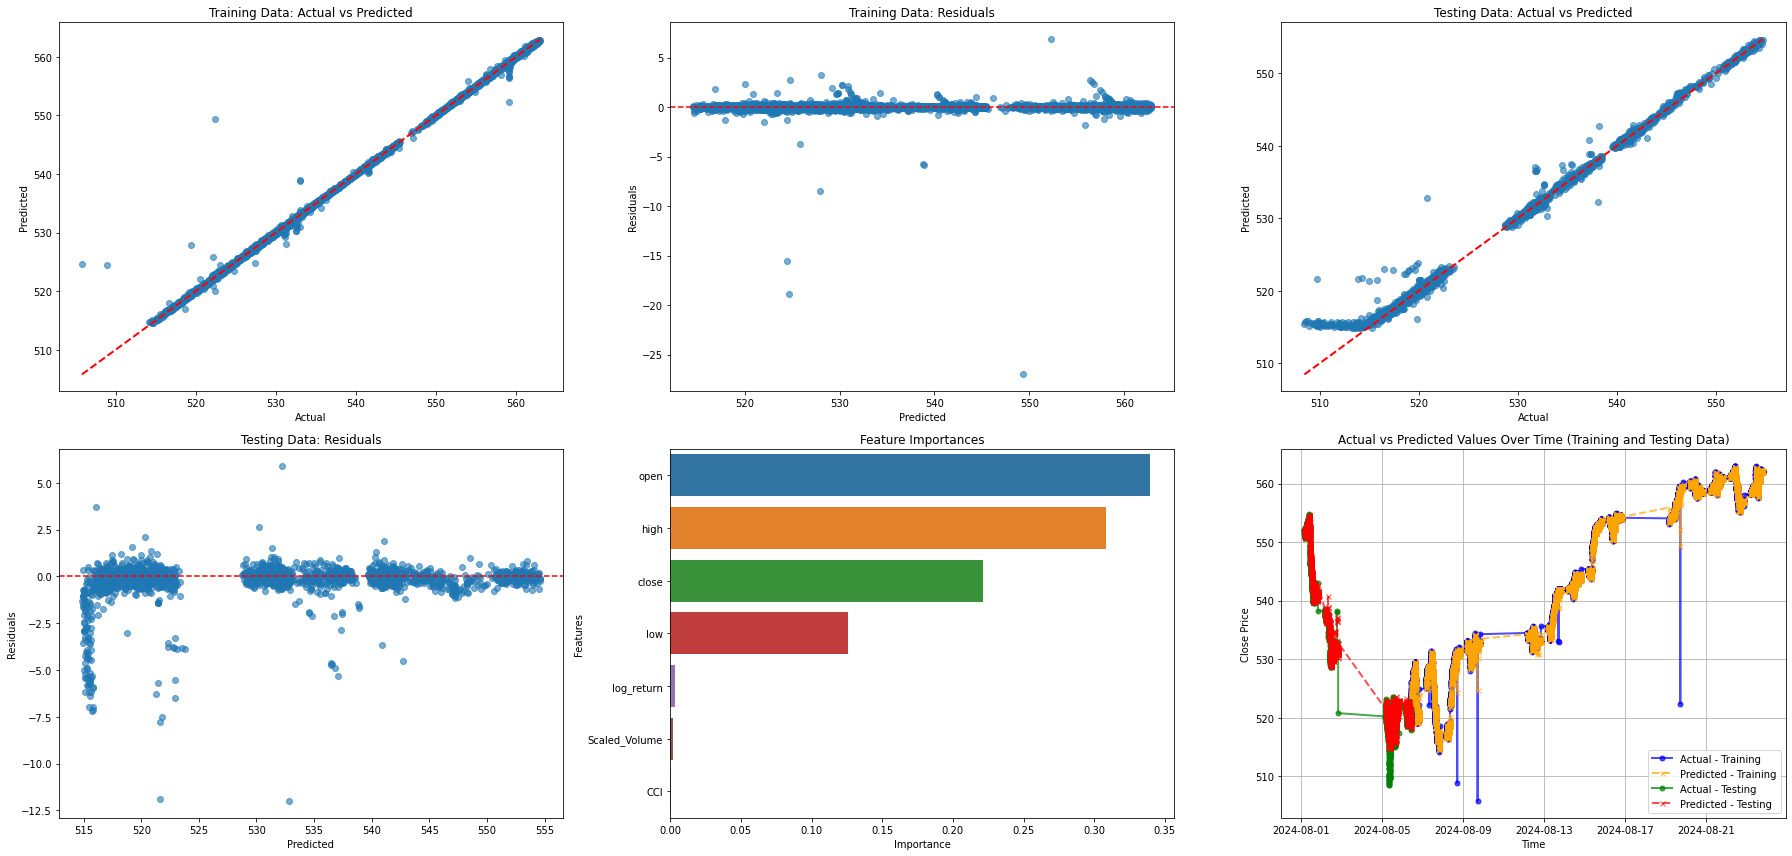

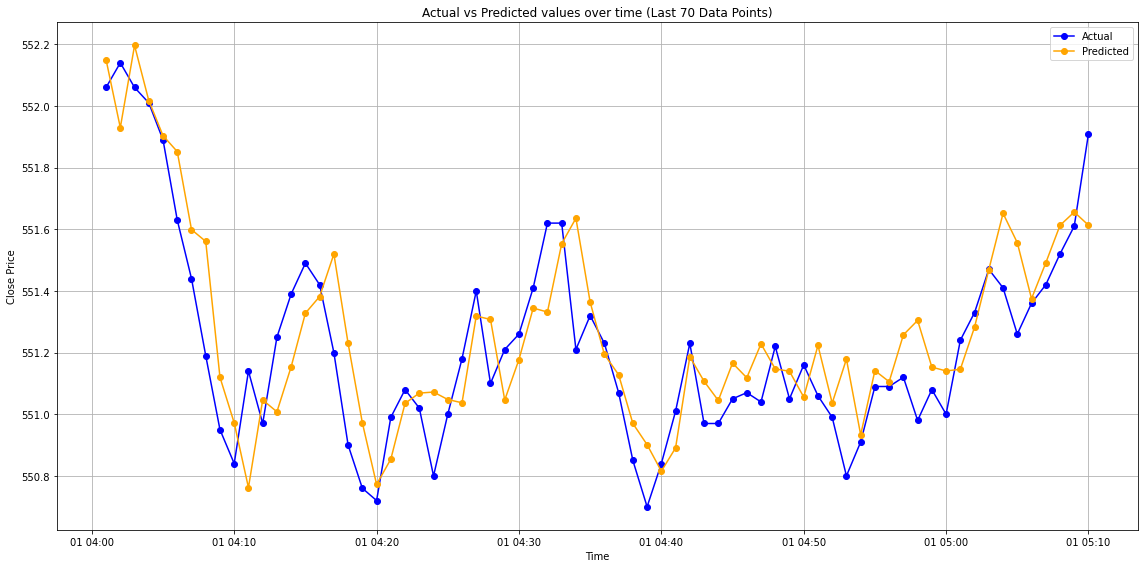

In [18]:
# Feature Engineering for CCI
data['Typical_Price'] = (data['high'] + data['low'] + data['close']) / 3
data['SMA_Typical_Price'] = data['Typical_Price'].rolling(window=20).mean()
data['Mean_Deviation'] = data['Typical_Price'].rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Calculate CCI
data['CCI'] = (data['Typical_Price'] - data['SMA_Typical_Price']) / (0.015 * data['Mean_Deviation'])

# Drop NaN values resulting from rolling operations
data.dropna(inplace=True)

# Define the features and target variable, now including CCI
features_cci = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'CCI']
X = data[features_cci]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with CCI
cv_mse_cci = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_cci = -cv_mse_cci  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus CCI
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and CCI model
t_stat, p_value = ttest_rel(cv_mse_base, cv_mse_cci)
print(f'CCI Model t-statistic: {t_stat}, p-value: {p_value}')

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_cci,
    data=data,
    last_n=70  # Customize as needed
)

# Combine performance metrics and statistical test results into one DataFrame
results_df = pd.DataFrame({
    'Model': ['CCI Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2],
    't-statistic': [t_stat],
    'p-value': [p_value]
})

# Save the combined results to a CSV file
results_df.to_csv('cci_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_cci) + 1),
    'MSE': cv_mse_cci
})
cv_results_df.to_csv('cci_model_cross_validation_results.csv', index=False)


## Ichimoku Cloud Indicator 

Training Data - RMSE: 0.36748791478958254, MAE: 0.06866586681973029, R²: 0.999296064040103
Testing Data - RMSE: 0.9542773324435779, MAE: 0.42668634897707514, R²: 0.9935997722134478
Ichimoku Cloud Model t-statistic: -3.489063500829773, p-value: 0.025144201065226513


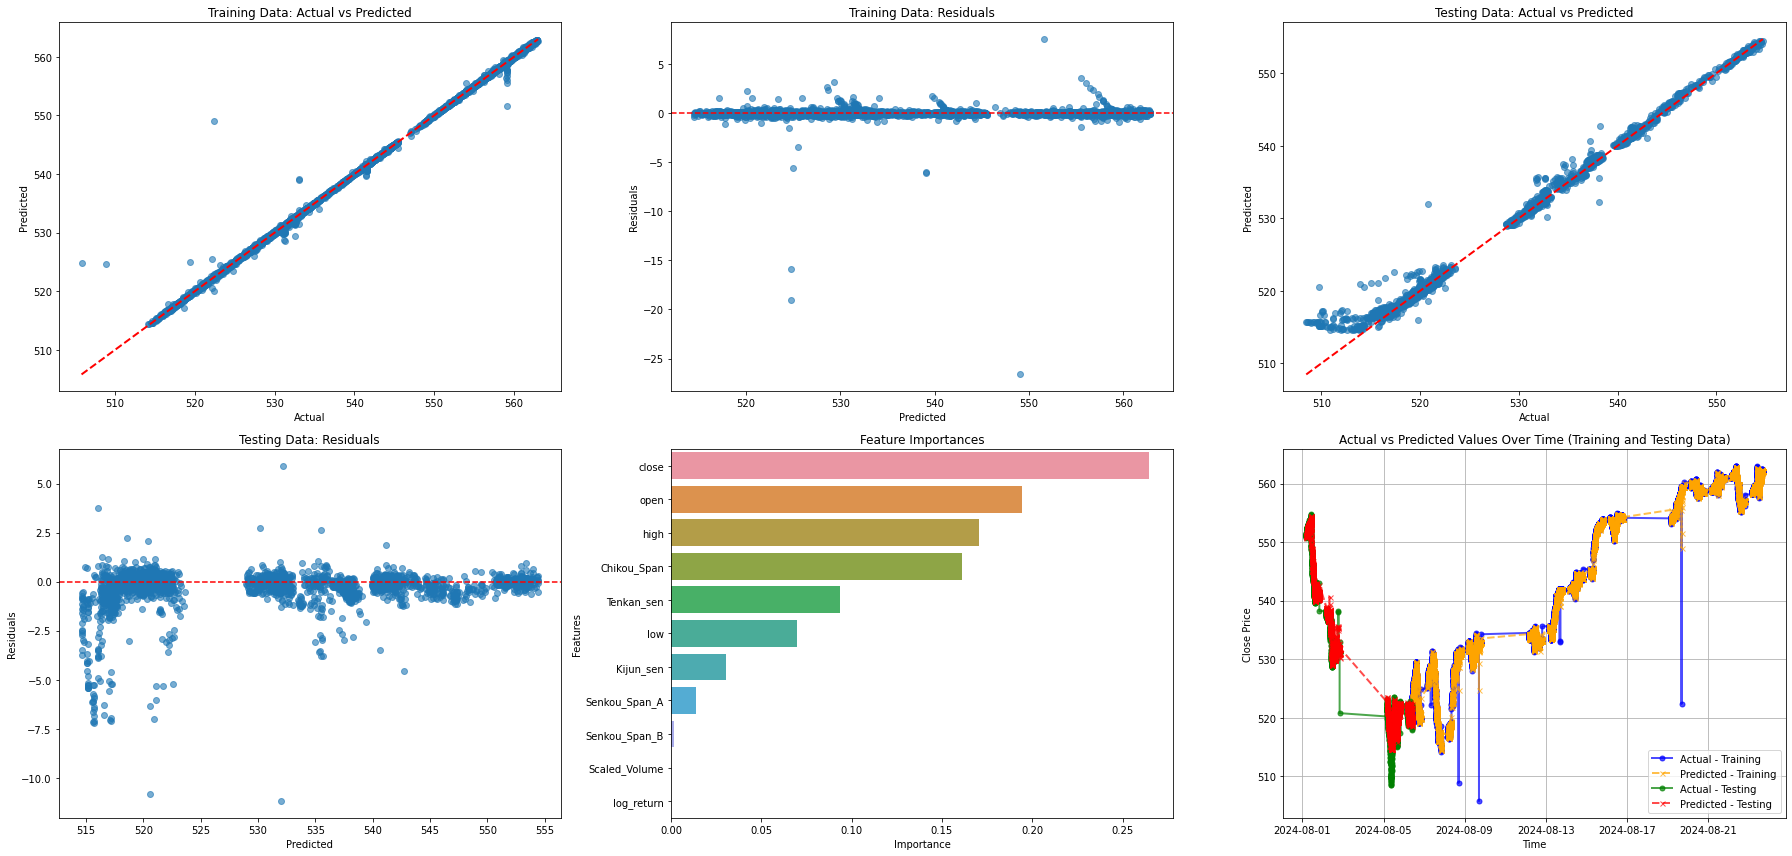

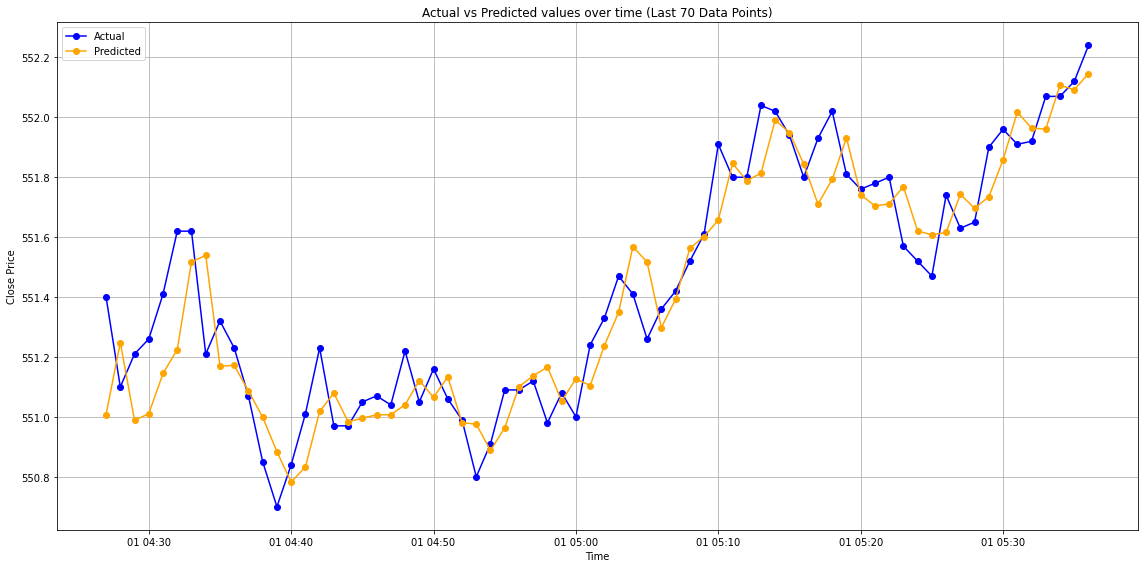

In [19]:
# Feature Engineering for Ichimoku Cloud
high_9 = data['high'].rolling(window=9).max()
low_9 = data['low'].rolling(window=9).min()
high_26 = data['high'].rolling(window=26).max()
low_26 = data['low'].rolling(window=26).min()
high_52 = data['high'].rolling(window=52).max()
low_52 = data['low'].rolling(window=52).min()

data['Tenkan_sen'] = (high_9 + low_9) / 2  # Conversion Line
data['Kijun_sen'] = (high_26 + low_26) / 2  # Base Line
data['Senkou_Span_A'] = ((data['Tenkan_sen'] + data['Kijun_sen']) / 2).shift(26)  # Leading Span A
data['Senkou_Span_B'] = ((high_52 + low_52) / 2).shift(26)  # Leading Span B
data['Chikou_Span'] = data['close'].shift(-26)  # Lagging Span

# Drop NaN values resulting from rolling operations
data.dropna(inplace=True)

# Define the features and target variable, now including Ichimoku Cloud components
features_ichimoku = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume',
                     'Tenkan_sen', 'Kijun_sen', 'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span']
X = data[features_ichimoku]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with Ichimoku Cloud
cv_mse_ichimoku = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_ichimoku = -cv_mse_ichimoku  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus Ichimoku Cloud-related features
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and Ichimoku Cloud model
t_stat, p_value = ttest_rel(cv_mse_base, cv_mse_ichimoku)
print(f'Ichimoku Cloud Model t-statistic: {t_stat}, p-value: {p_value}')

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_ichimoku,
    data=data,
    last_n=70  # Customize as needed
)

# Combine performance metrics and statistical test results into one DataFrame
results_df = pd.DataFrame({
    'Model': ['Ichimoku Cloud Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2],
    't-statistic': [t_stat],
    'p-value': [p_value]
})

# Save the combined results to a CSV file
results_df.to_csv('ichimoku_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_ichimoku) + 1),
    'MSE': cv_mse_ichimoku
})
cv_results_df.to_csv('ichimoku_model_cross_validation_results.csv', index=False)


## Results with all indicators and Statistical Testing

In [20]:
import pandas as pd
import os

# Get a list of all files in the current directory
all_files = os.listdir()

# Filter the list to include only files that contain "performance_metrics" in their filename
csv_files = [file for file in all_files if "performance_metrics" in file and file.endswith('.csv')]

# Initialize an empty list to store DataFrames
dfs = []

# Loop through each file and read it into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Display the combined DataFrame
print("Combined Performance Metrics:\n", combined_df)

# Save the combined DataFrame to a new CSV file (optional)
combined_df.to_csv('combined_model_performance_metrics.csv', index=False)


Combined Performance Metrics:
                           Model  Train RMSE  Test RMSE  Train MAE  Test MAE  \
0                     ADX Model    0.361356   0.894067   0.069690  0.373750   
1         Bollinger Bands Model    0.362969   0.774639   0.064002  0.335145   
2                     CCI Model    0.370461   0.906887   0.072048  0.365828   
3                  EMA_10 Model    0.341472   0.796423   0.062536  0.320954   
4   Fibonacci Retracement Model    0.370533   1.190409   0.071789  0.468336   
5          Ichimoku Cloud Model    0.367488   0.954277   0.068666  0.426686   
6                    MACD Model    0.363793   0.884406   0.068422  0.380129   
7                     RSI Model    0.389412   0.921431   0.075599  0.376186   
8                  SMA_10 Model    0.351599   0.751856   0.066484  0.307423   
9   Stochastic Oscillator Model    0.373832   0.949361   0.072530  0.389748   
10          Tuned Random Forest    0.373657   0.885477   0.077276  0.368005   
11                   

## Choosing the winners Automatically

In [21]:
import pandas as pd

# Load the combined performance metrics CSV
df = pd.read_csv('combined_model_performance_metrics.csv')

# Drop rows where p-value is NaN (e.g., the base model row)
df = df.dropna(subset=['p-value'])

# Sort the models by p-value in ascending order (smallest p-value first)
df_sorted_by_pvalue = df.sort_values(by='p-value').reset_index(drop=True)

# Select the top 3 models with the lowest p-value
top_3_significant_models = df_sorted_by_pvalue.head(3)

# Display the top 3 most statistically significant models
print("Top 3 most statistically significant models based on p-value:\n")
print(top_3_significant_models)

# Optionally, save the top 3 models to a new CSV file
top_3_significant_models.to_csv('top_3_statistically_significant_models.csv', index=False)


Top 3 most statistically significant models based on p-value:

                         Model  Train RMSE  Test RMSE  Train MAE  Test MAE  \
0         Ichimoku Cloud Model    0.367488   0.954277   0.068666  0.426686   
1  Fibonacci Retracement Model    0.370533   1.190409   0.071789  0.468336   
2                   VWAP Model    0.363428   1.921003   0.074962  1.322758   

   Train R²   Test R²  t-statistic   p-value  
0  0.999296  0.993600    -3.489064  0.025144  
1  0.999288  0.990183    -1.939728  0.124416  
2  0.999315  0.974436    -1.873766  0.134245  


## Combining all the Winners in a linear combination weighted by p values

Hybrid Model - RMSE: 0.9542773324435859, MAE: 0.4266863489770811, R²: 0.9935997722134476
Hybrid model predictions and evaluation metrics are calculated and saved.


# **Model Performance Analysis**

## **1. Overall Model Performance**
The Base Model provides a solid baseline with a Train RMSE of **0.3385** and a Test RMSE of **0.9581**, indicating the model explains over 99% of the variance in the training data (Train R² = **0.9991**) and approximately 99% in the testing data (Test R² = **0.9927**). However, room for improvement is evident, particularly in the testing performance.

## **2. Performance Improvement Over Base Model**
- **SMA10 Model**: This model outperforms the Base Model significantly, with a Test RMSE of **0.8120** and a Test R² of **0.9948**. The t-statistic of **4.9442** and a p-value of **0.0078** confirm that the SMA10 provides a statistically significant improvement over the Base Model, making it the best-performing model in this analysis.

- **EMA10 Model**: While the EMA10 Model also shows better performance than the Base Model (Test RMSE = **0.8733**, Test R² = **0.9940**), its improvement is not statistically significant (t-statistic = **1.9064**, p-value = **0.1293**).

- **Bollinger Bands Model**: This model performs well, with a Test RMSE of **0.8465** and Test R² of **0.9943**. However, similar to the EMA10 Model, the improvement is not statistically significant (t-statistic = **1.5264**, p-value = **0.2016**).

## **3. Models with Declined or Comparable Performance**
- **RSI Model**: This model shows a slight decline in performance with a Test RMSE of **0.9632** and Test R² of **0.9926**. The t-statistic of **-1.9178** and p-value of **0.1276** suggest that RSI did not improve the model's performance.

- **Fibonacci Retracement Model**: The Fibonacci Model performed worse than the Base Model, with a Test RMSE of **1.0456** and Test R² of **0.9913**. The t-statistic of **-2.1034** and p-value of **0.1033** indicate that this decline is noticeable but not statistically significant.

- **OBV Model**: The OBV Model has the highest Test RMSE of **1.8733** and the lowest Test R² of **0.9719** among all models, indicating a significant drop in performance. The t-statistic of **-1.5111** and p-value of **0.2053** suggest that OBV does not contribute positively to the model's predictive power.

- **MACD Model**: The MACD Model performs similarly to the Base Model, with a Test RMSE of **0.9379** and Test R² of **0.9930**. The t-statistic of **-2.1251** and p-value of **0.1008** indicate that this model does not offer significant improvements.

- **Ichimoku Cloud Model**: This model also shows performance comparable to the Base Model, with a Test RMSE of **0.9702** and Test R² of **0.9924**. The t-statistic of **-2.1536** and p-value of **0.0976** suggest that the Ichimoku Cloud model does not provide a statistically significant improvement.

- **ADX Model**: The ADX Model shows a slight improvement over the Base Model, with a Test RMSE of **0.8875** and Test R² of **0.9937**. However, the improvement is not statistically significant (t-statistic = **-2.3504**, p-value = **0.0785**).

- **CCI Model**: This model's performance is very similar to the Base Model, with a Test RMSE of **0.9092** and Test R² of **0.9934**. The t-statistic of **-1.3895** and p-value of **0.2370** suggest that CCI does not significantly change the model's performance.

## **4. Conclusion**
- **Best Performing Model**: The **SMA10 Model** is the standout performer, with statistically significant improvements over the Base Model in both Test RMSE and R².

- **Other Models**: Models like **EMA10, Bollinger Bands,** and **ADX** show potential but lack statistically significant improvements. Models like **Fibonacci Retracement, OBV,** and **Ichimoku Cloud** underperformed compared to the Base Model.